# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Remake" data-toc-modified-id="Remake-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Remake</a></div><div class="lev2 toc-item"><a href="#marker-genes-+-background-genes-selection-(now-reproducible)" data-toc-modified-id="marker-genes-+-background-genes-selection-(now-reproducible)-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>marker genes + background genes selection (now reproducible)</a></div><div class="lev2 toc-item"><a href="#synthetic-mixtures" data-toc-modified-id="synthetic-mixtures-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>synthetic mixtures</a></div><div class="lev1 toc-item"><a href="#pickle-out-the-synthetic-mixtures----so-we-can-load-into-cibersort-later" data-toc-modified-id="pickle-out-the-synthetic-mixtures----so-we-can-load-into-cibersort-later-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>pickle out the synthetic mixtures -- so we can load into cibersort later</a></div><div class="lev1 toc-item"><a href="#prepare-to-run-stan" data-toc-modified-id="prepare-to-run-stan-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>prepare to run stan</a></div><div class="lev1 toc-item"><a href="#Run-stan" data-toc-modified-id="Run-stan-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run stan</a></div><div class="lev1 toc-item"><a href="#Retrain-Cibersort-on-our-raw-samples" data-toc-modified-id="Retrain-Cibersort-on-our-raw-samples-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Retrain Cibersort on our raw samples</a></div><div class="lev1 toc-item"><a href="#Train-Cibersort-into-new-signature-matrix-and-run-on-synthetic-mixtures" data-toc-modified-id="Train-Cibersort-into-new-signature-matrix-and-run-on-synthetic-mixtures-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train Cibersort into new signature matrix and run on synthetic mixtures</a></div><div class="lev1 toc-item"><a href="#Run-Cibersort-with-LM22" data-toc-modified-id="Run-Cibersort-with-LM22-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Run Cibersort with LM22</a></div><div class="lev2 toc-item"><a href="#debug-log-from-doing-this-in-a-adhoc-docker-container" data-toc-modified-id="debug-log-from-doing-this-in-a-adhoc-docker-container-71"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>debug log from doing this in a adhoc docker container</a></div><div class="lev2 toc-item"><a href="#code-from-old-notebooks-for-reference" data-toc-modified-id="code-from-old-notebooks-for-reference-72"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>code from old notebooks for reference</a></div><div class="lev1 toc-item"><a href="#Load-in-stan-results" data-toc-modified-id="Load-in-stan-results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Load in stan results</a></div><div class="lev1 toc-item"><a href="#Convergence-checks." data-toc-modified-id="Convergence-checks.-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Convergence checks.</a></div><div class="lev1 toc-item"><a href="#get-the-full-deconvolution-distributions" data-toc-modified-id="get-the-full-deconvolution-distributions-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>get the full deconvolution distributions</a></div><div class="lev1 toc-item"><a href="#Plot" data-toc-modified-id="Plot-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Plot</a></div><div class="lev1 toc-item"><a href="#Plot-rollups" data-toc-modified-id="Plot-rollups-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Plot rollups</a></div><div class="lev1 toc-item"><a href="#Traceplots-and-correlation-matrix" data-toc-modified-id="Traceplots-and-correlation-matrix-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Traceplots and correlation matrix</a></div><div class="lev1 toc-item"><a href="#Cibersort's-diagnostics" data-toc-modified-id="Cibersort's-diagnostics-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Cibersort's diagnostics</a></div>

We're going to remake the same synthetic mixtures we ran through out Stan model.

Sadly our list of selected genes was not saved. So we have to rerun Stan on these mixtures.

Then we'll run them thru Cibersort.

Then we'll produce new figures with Cibersort results overlaid.

The `logs/*` files from this experiment are archived at: `/data/modelcache_new/experiments/20170831_2.1.1markergenes`

# Remake

Based on `2.1_oos_syntheticmixtures_markergenes.py` -- with significant changes

## marker genes + background genes selection (now reproducible)



In [169]:
import numpy as np
import matplotlib as mpl
import data
import models
import cache
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pystan
from time import time
from datetime import timedelta
import pickle
import dill

In [170]:
# verify kernel won't crash due to MKL issue from future imports
import sklearn.linear_model.tests.test_randomized_l1

In [3]:
bindea = pd.read_csv('../curated_data/pure_samples/bindea/Bindea Immunome - Bindea paper.csv')
bindea.head()

,CellType,Symbol,AffymetrixID,UGCluster,EntrezGene,Name
0,aDC,CCL1,207533_at,Hs.72918,6346,chemokine (C-C motif) ligand 1
1,aDC,EBI3,219424_at,Hs.501452,10148,Epstein-Barr virus induced gene 3
2,aDC,INDO,210029_at,Hs.840,3620,"indoleamine-pyrrole 2,3 dioxygenase"
3,aDC,LAMP3,205569_at,Hs.518448,27074,lysosomal-associated membrane protein 3
4,aDC,OAS3,218400_at,Hs.528634,4940,"2'-5'-oligoadenylate synthetase 3, 100kDa"


In [4]:
marker_genes = bindea.Symbol.unique()
len(marker_genes)

579

In [5]:
model_name = 'model6.2'
by = 'SubSet'
total_num_genes = 800 # number we want to have total

In [6]:
sample_df = cache.cached(models.prep_sample_df,
                         sample_n=None)

INFO:stancache.stancache:prep_sample_df: cache_filename set to prep_sample_df.cached.sample_n_82429761595.pkl
INFO:stancache.stancache:prep_sample_df: Starting execution
INFO:stancache.stancache:prep_annotated_data: cache_filename set to prep_annotated_data.cached.default.pkl
INFO:stancache.stancache:prep_annotated_data: Starting execution
INFO:stancache.stancache:prep_annotated_data: Execution completed (0:12:57.256852 elapsed)
INFO:stancache.stancache:prep_annotated_data: Saving results to cache
INFO:stancache.stancache:prep_sample_df: Execution completed (0:13:12.366902 elapsed)
INFO:stancache.stancache:prep_sample_df: Saving results to cache


In [14]:
sample_df.SubSet.unique()

array(['CD4_Th2', 'CD8_Effector', 'B_CD5', 'B_Memory', 'CD4_Th1',
       'CD4_Naive', 'B_Naive', 'CD4_Effector_Memory', 'CD8_Central_Memory',
       'CD4_Central_Memory', 'CD4_Treg', 'CD8_Naive', 'CD4_Th17'], dtype=object)

In [15]:
all_genes = sample_df.gene_name.unique()
marker_genes_adjusted = list(set(marker_genes) - (set(marker_genes) - set(all_genes)))
genes_to_sample_from = list(set(all_genes) - set(marker_genes_adjusted))
print('desired size:', total_num_genes-len(marker_genes_adjusted))
sampled_genes = np.random.choice(genes_to_sample_from, size=total_num_genes-len(marker_genes_adjusted))
len(sampled_genes)

desired size: 281


281

In [26]:
selected_genes = np.concatenate([marker_genes_adjusted, sampled_genes]).tolist()
assert len(selected_genes) == total_num_genes

In [28]:
# pickle out selected gene list
import pickle
pickle.dump(selected_genes, open('logs/2.1.1_selectedgenes.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)

In [171]:
selected_genes = pickle.load(open('logs/2.1.1_selectedgenes.pkl', 'rb'))

In [172]:
filtered_sample_df = cache.cached(models.prep_sample_df,
                                 sample_gene_list=selected_genes)

INFO:stancache.stancache:prep_sample_df: cache_filename set to prep_sample_df.cached.sample_gene_list_14312972822.pkl
INFO:stancache.stancache:prep_sample_df: Loading result from cache


In [30]:
sample_df.shape, filtered_sample_df.shape

((2194416, 41), (50274, 41))

In [31]:
len(filtered_sample_df.gene_name.unique())

798

In [32]:
print('filtered sample df number of genes:', len(filtered_sample_df.gene_name.unique()))

filtered sample df number of genes: 798


In [33]:
pickle.dump(filtered_sample_df.gene_name.unique().tolist(),
            open('logs/2.1.1_selectedgenes.TRUE.pkl', 'wb'),
            pickle.HIGHEST_PROTOCOL)

In [173]:
training_df = filtered_sample_df

## synthetic mixtures

In [36]:
model_file = models.get_model_file(model_name=model_name)
stan_data = models.prep_stan_data(sample_df=training_df, test_df=None, by=by)
stan_data

{'C': 13,
 'G': 798,
 'M': 20,
 'N': 50274,
 'S': 63,
 'cell_features':                      CCR6+  CCR7+  CCR7-  CD127-  CD161+  CD19+  CD25+  CD27+  \
 SubSet                                                                          
 CD4_Th2                0.0    0.0    0.0     0.0     0.0    0.0    0.0    0.0   
 CD8_Effector           0.0    0.0    1.0     0.0     0.0    0.0    0.0    0.0   
 B_CD5                  0.0    0.0    0.0     0.0     0.0    1.0    0.0    0.0   
 B_Memory               0.0    0.0    0.0     0.0     0.0    1.0    0.0    1.0   
 CD4_Th1                0.0    0.0    0.0     0.0     0.0    0.0    0.0    0.0   
 CD4_Naive              0.0    1.0    0.0     0.0     0.0    0.0    0.0    0.0   
 B_Naive                0.0    0.0    0.0     0.0     0.0    1.0    0.0    0.0   
 CD4_Effector_Memory    0.0    0.0    1.0     0.0     0.0    0.0    0.0    0.0   
 CD8_Central_Memory     0.0    1.0    0.0     0.0     0.0    0.0    0.0    0.0   
 CD4_Central_Memory     0.0

In [35]:
def get_sample_ids_by_subset(training_df):
    return {subset: 
            sample_df[sample_df['SubSet'] == subset].new_sample_id.unique() for subset in sample_df.SubSet.unique()}
relevant_sample_ids = get_sample_ids_by_subset(training_df)
assert all([len(relevant_sample_ids[i]) > 0 for i in relevant_sample_ids])
relevant_sample_ids

{'B_CD5': array([ 3, 26, 31, 34]),
 'B_Memory': array([ 4, 29, 43, 48, 52]),
 'B_Naive': array([ 7, 21, 46, 54, 59]),
 'CD4_Central_Memory': array([17, 33, 49, 55, 61]),
 'CD4_Effector_Memory': array([10, 11, 23, 38, 51]),
 'CD4_Naive': array([ 6,  9, 15, 16, 45]),
 'CD4_Th1': array([ 5, 12, 19, 22, 57]),
 'CD4_Th17': array([30, 32, 39, 53, 60]),
 'CD4_Th2': array([ 1, 14, 35, 50, 63]),
 'CD4_Treg': array([18, 24, 36, 41, 44]),
 'CD8_Central_Memory': array([13, 28, 37, 42]),
 'CD8_Effector': array([ 2,  8, 20, 25, 56]),
 'CD8_Naive': array([27, 40, 47, 58, 62])}

In [39]:
def mix_cell_lines(sample_df, xdata, subsets, weights, sample_ids=None, new_sample_id=10001):
    """
    e.g. xdata=stan_data['x'], subsets=['B_Naive', 'B_Memory'], weights=[.5, .5], sample_ids=None
    if sample_ids are None, the first sample of each subset is used
    """
    
    assert len(weights) == len(subsets)
    if sample_ids:
        # confirm sample ids belong to the subsets we expect them to belong to.
        for subset, sample_id in zip(subsets, sample_ids):
            assert sample_id in relevant_sample_ids[subset]
    else:
        sample_ids = [relevant_sample_ids[subset][0] for subset in subsets]
    
    weights = np.array(weights)
    weights = weights / np.sum(weights) # normalize
    
    x2_data = pd.DataFrame(np.zeros((1, xdata.shape[1])), columns=xdata.columns)
    
    transformed_lines = []
    for subset, weight, sample_id in zip(subsets, weights, sample_ids):
        transformed = sample_df[sample_df['new_sample_id'] == sample_id].copy()
        transformed.loc[:,'est_counts'] *= weight
        transformed_lines.append(transformed)
        x2_data['SubSet[%s]' % subset] = weight
    
    mixed_sample = pd.concat(transformed_lines).groupby(         ['gene_name', 'new_gene_id'])['est_counts']        .sum().reset_index()
        
    mixed_sample['sample_id'] = new_sample_id
    
    return mixed_sample, x2_data

In [40]:
mix_cell_lines(sample_df=training_df, xdata=stan_data['x'], subsets=['B_Naive', 'B_Memory'], weights=[.5, .5], sample_ids=None)


(        gene_name  new_gene_id   est_counts  sample_id
 0           ABCB4            1   206.156191      10001
 1           ABCC4            2    96.394805      10001
 2           ABCG2            3     6.000000      10001
 3           ABHD2            4   556.193123      10001
 4            ABT1            5   359.500000      10001
 5      AC006483.5            6     0.000000      10001
 6      AC006486.9            7    26.421405      10001
 7      AC009414.1            8     0.000000      10001
 8      AC011295.1            9     0.863155      10001
 9      AC069282.6           10    67.500000      10001
 10    AC087380.14           11     2.500000      10001
 11     AC093166.2           12     0.000000      10001
 12     AC109815.2           13     0.000000      10001
 13     AC114814.2           14     0.000000      10001
 14     AC123900.2           15     0.000000      10001
 15          ACACB           16   284.955338      10001
 16          ACBD3           17   639.999975    

In [41]:
# here are the mixtures we want
mix1, mix1_x = mix_cell_lines(sample_df=training_df,
                              xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.5, .5],
                              sample_ids=[7, 4],
                              new_sample_id = 10001)

mix2, mix2_x = mix_cell_lines(sample_df=training_df,
                              xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.5, .5],
                              sample_ids=[21, 29],
                              new_sample_id = 10002)

mix3, mix3_x = mix_cell_lines(sample_df=training_df,
                              xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.25, .75],
                              sample_ids=[7, 4],
                              new_sample_id = 10003)

mix4, mix4_x = mix_cell_lines(sample_df=training_df,
                              xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.25, .75],
                              sample_ids=[21, 29],
                              new_sample_id = 10004)

mix5, mix5_x = mix_cell_lines(sample_df=training_df,
                              xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.75, .25],
                              sample_ids=[7, 4],
                              new_sample_id = 10005)

mix6, mix6_x = mix_cell_lines(sample_df=training_df,
                              xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.75, .25],
                              sample_ids=[21, 29],
                              new_sample_id = 10006)

# tregs vs naive B cells

mix7, mix7_x = mix_cell_lines(sample_df=training_df,
                              xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.5, .5],
                              sample_ids=[7, 18],
                              new_sample_id = 10007)

mix8, mix8_x = mix_cell_lines(sample_df=training_df,
                              xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.25, .75],
                              sample_ids=[7, 18],
                              new_sample_id = 10008)

mix9, mix9_x = mix_cell_lines(sample_df=training_df,
                              xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.5, .5],
                              sample_ids=[21, 24],
                              new_sample_id = 10009)

mix10, mix10_x = mix_cell_lines(sample_df=training_df,
                                xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.25, .75],
                              sample_ids=[21, 24],
                              new_sample_id = 10010)

In [42]:
# make a test_df and x2_data with all of them
test_df = pd.concat([mix1, mix2, mix3, mix4, mix5, mix6, mix7, mix8, mix9, mix10])
test_df['gene_id'] = test_df['new_gene_id']
x2_data = pd.concat([mix1_x,mix2_x,mix3_x,mix4_x,mix5_x,mix6_x,mix7_x,mix8_x,mix9_x,mix10_x])

In [53]:
for dat in [training_df, test_df]:
    dat.sort_values(['gene_id','sample_id'], inplace=True)
    dat['new_sample_cat'] = dat['sample_id'].astype('category')
    dat['new_sample_id'] = dat['new_sample_cat'].cat.codes+1

In [54]:
test_df.head()

,gene_name,new_gene_id,est_counts,sample_id,gene_id,new_sample_cat,new_sample_id
0,ABCB4,1,206.156191,10001,1,10001,1
0,ABCB4,1,759.406680,10002,1,10002,2
0,ABCB4,1,173.078081,10003,1,10003,3
0,ABCB4,1,444.020830,10004,1,10004,4
0,ABCB4,1,239.234300,10005,1,10005,5


In [55]:
x2_data.head()

,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive]
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.25,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# pickle out the synthetic mixtures -- so we can load into cibersort later

In [56]:
synthetic_mixtures = test_df.pivot(index='gene_name', columns='sample_id', values='est_counts')
synthetic_mixtures.head()

sample_id,10001,10002,10003,10004,10005,10006,10007,10008,10009,10010
gene_name,,,,,,,,,,
ABCB4,206.156191,759.406680,173.078081,444.020830,239.234300,1074.792531,138.156205,71.078102,695.589191,348.294596
ABCC4,96.394805,76.717060,131.041307,103.204185,61.748302,50.229935,67.409040,87.562660,67.534150,89.429820
ABCG2,6.000000,4.500000,6.000000,3.750000,6.000000,5.250000,23.499985,32.249977,13.499990,17.249985
ABHD2,556.193123,863.839295,602.581480,760.617562,509.804767,967.061028,934.681040,1170.313355,1127.120825,1155.539857
ABT1,359.500000,689.500000,434.750000,596.750000,284.250000,782.250000,344.500000,412.250000,719.000000,641.000000


In [57]:
synthetic_groundtruth = x2_data.transpose()
synthetic_groundtruth.columns = synthetic_mixtures.columns
synthetic_groundtruth.head()

sample_id,10001,10002,10003,10004,10005,10006,10007,10008,10009,10010
SubSet[B_CD5],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[B_Memory],0.5,0.5,0.75,0.75,0.25,0.25,0.0,0.00,0.0,0.00
SubSet[B_Naive],0.5,0.5,0.25,0.25,0.75,0.75,0.5,0.25,0.5,0.25
SubSet[CD4_Central_Memory],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Effector_Memory],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00


In [122]:
pickle.dump({'y_test': synthetic_mixtures, 'x_test': synthetic_groundtruth},
            open('logs/2.1.1_syntheticmixtures.pkl', 'wb'),
            pickle.HIGHEST_PROTOCOL)

synthetic_mixtures.to_csv('logs/2.1.1_syntheticmixtures.ytest.csv')
synthetic_mixtures.to_csv('logs/2.1.1_syntheticmixtures.ytest.tsv', sep='\t')
synthetic_groundtruth.to_csv('logs/2.1.1_syntheticmixtures.xtest.csv')

In [174]:
syntheticmixes = pickle.load(open('logs/2.1.1_syntheticmixtures.pkl', 'rb'))
synthetic_mixtures = syntheticmixes['y_test']
synthetic_groundtruth = syntheticmixes['x_test']

# prepare to run stan

In [59]:
test_data = {'N2': len(test_df.index),
             'S2': len(test_df.new_sample_id.unique()),
             'gene2': test_df.new_gene_id.values,
             'sample2': test_df.new_sample_id.values,
             'y2': test_df.est_counts.astype(int).values,
             'x2': x2_data, ## for easy access later
             }

stan_data.update(test_data)

In [60]:
stan_data['G']

798

In [62]:
pickle.dump(stan_data,
            open('logs/2.1.1_standata.pkl', 'wb'),
            pickle.HIGHEST_PROTOCOL)

In [175]:
stan_data = pickle.load(open('logs/2.1.1_standata.pkl', 'rb'))

# Run stan

To do so, we will actually run a python script saved out: `2.1.1_RunStan.py`.

To run interactively, we launch: `python -i 2.1.1_RunStan.py 2>&1 | tee logs/2.1.1_RunStan.py.consoleout.txt`

Do that from within a `docker exec -it maximz-dev-2 bash` shell. If you want, can `su jovyan` first.

# Retrain Cibersort on our raw samples

In [66]:
training_df.head()

,index,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6+,CCR7+,...,log1p_tpm_rescaled_subset,log1p_tpm_rescaled,gene_cat,gene_id,B_cell,T_cell,new_gene_cat,new_gene_id,new_sample_cat,new_sample_id
0,0,1,ERR431566,ABCB4,1.000000,0.851882,0.616202,0.693147,0.0,0.0,...,1.998440,-0.188314,ABCB4,70,0,1,ABCB4,1,1,1
1,1,2,ERR431567,ABCB4,2.000000,0.397441,0.334642,1.098612,0.0,0.0,...,-0.115750,-0.636778,ABCB4,70,0,1,ABCB4,1,2,2
2,2,3,ERR431568,ABCB4,782.000170,28.925644,3.398716,6.663133,0.0,0.0,...,-6.838006,4.243620,ABCB4,70,1,0,ABCB4,1,3,3
3,3,4,ERR431569,ABCB4,139.999971,5.299960,1.840543,4.948760,0.0,0.0,...,-3.955303,1.761793,ABCB4,70,1,0,ABCB4,1,4,4
4,4,5,ERR431570,ABCB4,3.007070,0.197082,0.179887,1.388060,0.0,0.0,...,-2.390764,-0.883270,ABCB4,70,0,1,ABCB4,1,5,5


In [94]:
cibersort_reference = training_df.pivot(index='gene_name', columns='sample_id', values='est_counts')
cibersort_reference.head()

sample_id,1,2,3,4,5,6,7,8,9,10,...,54,55,56,57,58,59,60,61,62,63
gene_name,,,,,,,,,,,,,,,,,,,,,
ABCB4,1.000000,2.00000,782.00017,139.999971,3.00707,5.000000,272.31241,1.00000,14.03124,2.002061,...,396.427795,5.999999,8.999999,12.02080,4.00347,901.83768,4.00000,6.000000,7.000000,2.000000
ABCC4,174.714850,71.38846,11.24475,165.687810,59.50698,286.581810,27.10180,141.34336,177.54349,87.161680,...,12.107020,59.083843,72.030390,43.87995,87.84840,43.16080,54.91326,62.594610,162.481127,201.262660
ABCG2,43.000021,2.00000,5.00000,6.000000,6.00000,19.999975,6.00000,16.00000,44.99996,35.000000,...,2.000000,48.000000,21.999970,8.00000,26.00002,3.00000,36.00000,36.999966,18.000000,30.999997
ABHD2,870.505410,638.55064,612.95028,648.969836,819.47966,1413.857660,463.41641,790.15101,2553.48020,1082.887390,...,318.781630,1161.321060,1204.681780,903.92156,940.85575,470.75543,838.73480,1061.965090,625.161400,1200.626050
ABT1,276.000000,346.00000,644.00000,510.000000,324.00000,604.000000,209.00000,599.00000,1350.00000,461.000000,...,241.000000,483.000000,562.000000,301.00000,636.00000,358.00000,234.00000,453.000000,439.000000,349.000000


In [119]:
cibersort_reference.to_csv('2.1.1_cibersort_reference.txt', sep='\t')

In [120]:
!head -n 1 2.1.1_cibersort_reference.txt

gene_name	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63


In [82]:
map_sampleid_to_subset = training_df.groupby('sample_id').SubSet.first()
map_sampleid_to_subset.head()

sample_id
1         CD4_Th2
2    CD8_Effector
3           B_CD5
4        B_Memory
5         CD4_Th1
Name: SubSet, dtype: object

In [121]:
map_sampleid_to_subset.to_csv('2.1.1_debug_sampleid_map_to_subset.txt', sep='\t')

In [87]:
presence_of_subset_in_sample = models.patsy_helper_nointercept(df=pd.DataFrame({'SubSet':map_sampleid_to_subset}), formula='SubSet').transpose()
presence_of_subset_in_sample.head()

sample_id,1,2,3,4,5,6,7,8,9,10,...,54,55,56,57,58,59,60,61,62,63
SubSet[B_CD5],0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SubSet[B_Memory],0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SubSet[B_Naive],0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
SubSet[CD4_Central_Memory],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
SubSet[CD4_Effector_Memory],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
# each subset is present in a few samples
presence_of_subset_in_sample.sum(axis=1)

SubSet[B_CD5]                  4.0
SubSet[B_Memory]               5.0
SubSet[B_Naive]                5.0
SubSet[CD4_Central_Memory]     5.0
SubSet[CD4_Effector_Memory]    5.0
SubSet[CD4_Naive]              5.0
SubSet[CD4_Th1]                5.0
SubSet[CD4_Th17]               5.0
SubSet[CD4_Th2]                5.0
SubSet[CD4_Treg]               5.0
SubSet[CD8_Central_Memory]     4.0
SubSet[CD8_Effector]           5.0
SubSet[CD8_Naive]              5.0
dtype: float64

In [91]:
# each sample only includes one subset
presence_of_subset_in_sample.sum(axis=0)

sample_id
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
     ... 
34    1.0
35    1.0
36    1.0
37    1.0
38    1.0
39    1.0
40    1.0
41    1.0
42    1.0
43    1.0
44    1.0
45    1.0
46    1.0
47    1.0
48    1.0
49    1.0
50    1.0
51    1.0
52    1.0
53    1.0
54    1.0
55    1.0
56    1.0
57    1.0
58    1.0
59    1.0
60    1.0
61    1.0
62    1.0
63    1.0
dtype: float64

In [116]:
# recode according to cibersort expected values: 1 is "present", 2 is "not present", 0 is "ignore"
cibersort_classes = presence_of_subset_in_sample.replace(0, 2).astype(int)
cibersort_classes = cibersort_classes.set_index(cibersort_classes.index.astype(str).str.replace(']', '').str.replace('[', '').str.replace('SubSet', ''))
cibersort_classes

sample_id,1,2,3,4,5,6,7,8,9,10,...,54,55,56,57,58,59,60,61,62,63
B_CD5,2,2,1,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
B_Memory,2,2,2,1,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
B_Naive,2,2,2,2,2,2,1,2,2,2,...,1,2,2,2,2,1,2,2,2,2
CD4_Central_Memory,2,2,2,2,2,2,2,2,2,2,...,2,1,2,2,2,2,2,1,2,2
CD4_Effector_Memory,2,2,2,2,2,2,2,2,2,1,...,2,2,2,2,2,2,2,2,2,2
CD4_Naive,2,2,2,2,2,1,2,2,1,2,...,2,2,2,2,2,2,2,2,2,2
CD4_Th1,2,2,2,2,1,2,2,2,2,2,...,2,2,2,1,2,2,2,2,2,2
CD4_Th17,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,1,2,2,2
CD4_Th2,1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,1
CD4_Treg,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [117]:
cibersort_classes.to_csv('2.1.1_cibersort_classes.txt', header=None, sep='\t')

In [176]:
cibersort_classes = pd.read_csv('2.1.1_cibersort_classes.txt', header=None, index_col=0, sep='\t')
cibersort_classes.head()

,1,2,3,4,5,6,7,8,9,10,...,54,55,56,57,58,59,60,61,62,63
0,,,,,,,,,,,,,,,,,,,,,
B_CD5,2,2,1,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
B_Memory,2,2,2,1,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
B_Naive,2,2,2,2,2,2,1,2,2,2,...,1,2,2,2,2,1,2,2,2,2
CD4_Central_Memory,2,2,2,2,2,2,2,2,2,2,...,2,1,2,2,2,2,2,1,2,2
CD4_Effector_Memory,2,2,2,2,2,2,2,2,2,1,...,2,2,2,2,2,2,2,2,2,2


In [118]:
!cat 2.1.1_cibersort_classes.txt

B_CD5	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	1	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2
B_Memory	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	1	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2
B_Naive	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	1	2	2	2	2	1	2	2	2	2
CD4_Central_Memory	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	1	2	2	2	2	2	1	2	2
CD4_Effector_Memory	2	2	2	2	2	2	2	2	2	1	1	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2
CD4_Naive	2	2	2	2	2	1	2	2	1	2	2	2	2	2	1	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2
CD4_Th1	2	2	2	2	1	2	2	2	2	2	2	1	2	2	2	2	2	2	1	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2
CD4_Th17	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2

# Train Cibersort into new signature matrix and run on synthetic mixtures

In [ ]:
!java -jar -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar \ 
-M logs/2.1.1_syntheticmixtures.ytest.tsv \ 
-P 2.1.1_cibersort_reference.txt \ 
-c 2.1.1_cibersort_classes.txt \ 
-n 100 -v -q 0.3 -k 999 -m 50 -x 150 -f True

In [177]:
tmp_output="""
Column	B_CD5	B_Memory	B_Naive	CD4_Central_Memory	CD4_Effector_Memory	CD4_Naive	CD4_Th1	CD4_Th17	CD4_Th2	CD4_Treg	CD8_Central_Memory	CD8_Effector	CD8_Naive	P-value	Pearson Correlation	RMSE	%Completed
0	0.05157774940478405	0.4593524849565805	0.22226173357239154	0	0	0.03498559869884739	0.06008597871643464	0.03350944522574015	0	0.027812010380022203	0	0.11041499904519955	0	0.0	0.9717890376864418	0.28360878427837094	10.0
1	0.16806379438666907	0.3736324895056559	0.3314752671939038	0.032893518140446366	0	0	0.04619126120949254	0	0.025784392472946577	0	0.0012230880789133446	0.02073618901197236	0	0.0	0.9818967932445514	0.33989628943750194	20.0
2	0	0.55840065829877	0.18426543662085673	0	0	0.03239251237080184	0.12010684789258395	0	0	0.019086160795638372	0	0.0857483840213492	0	0.0	0.9749122214954071	0.2954471719717012	30.0
3	0.04741853806158877	0.5685869558327992	0.2156118990236357	0.06811434377227708	0.04102335959290386	0	0	0	0.02991815003852629	0	0.00500792098624831	0	0.024318832692020835	0.0	0.9868180150352841	0.3268583363254266	40.0
4	0.31581924439256187	0.33082879181474034	0.11027072520464241	0	0	0.02678345794561726	0.020505754709162383	0.03938837391497302	0	0	0	0.1564036520183027	0	0.0	0.9709673494023213	0.2735882735344397	50.0
5	0.17505344187890337	0.16001057678650685	0.47555417328110033	0.018589650380227692	0	0	0.0666020745073377	0.006063716904672242	0.022876391023684734	0	0	0.04796627223098806	0.02728370300657906	0.0	0.9615606739615541	0.3363662251534946	60.0
6	0.29008926941426166	0	0.04634175589271763	0.021105167245280113	0.036781309290672796	0	0	0	0.003015382797152038	0.5453438770409766	0	0.05732323831893921	0	0.0	0.9602507084699228	0.45279228411711864	70.0
7	0.037475355281655576	0.007389169200173536	0.10684354397433582	0.026653286783055976	0.07315214584458288	0	0	0	0	0.7375986019904411	0	0.010887896925755118	0	0.0	0.9753012053284533	0.44290610172823325	80.0
8	0.22962007066508794	0.003317040844248509	0.21930686197467114	0	0	0	0.07297235145118046	0.06702929201905101	0.1430619491071055	0.2502197892498369	0.014472644688818523	0	0	0.0	0.942548336448828	0.41032848180074294	90.0
9	0.12284021852810813	0.011321554301012296	0.0742846294688371	0	0.013699907721148872	0	0.007480132344298996	0.09030181152265049	0.19408895234152826	0.4685790795205317	0.017403714251884236	0	0	0.0	0.9492508700202033	0.4868058255498496	100.0
"""

In [178]:
from io import StringIO
example_result = pd.read_csv(StringIO(tmp_output), sep='\t')
example_result

,Column,B_CD5,B_Memory,B_Naive,CD4_Central_Memory,CD4_Effector_Memory,CD4_Naive,CD4_Th1,CD4_Th17,CD4_Th2,CD4_Treg,CD8_Central_Memory,CD8_Effector,CD8_Naive,P-value,Pearson Correlation,RMSE,%Completed
0,0,0.051578,0.459352,0.222262,0.000000,0.000000,0.034986,0.060086,0.033509,0.000000,0.027812,0.000000,0.110415,0.000000,0.0,0.971789,0.283609,10.0
1,1,0.168064,0.373632,0.331475,0.032894,0.000000,0.000000,0.046191,0.000000,0.025784,0.000000,0.001223,0.020736,0.000000,0.0,0.981897,0.339896,20.0
2,2,0.000000,0.558401,0.184265,0.000000,0.000000,0.032393,0.120107,0.000000,0.000000,0.019086,0.000000,0.085748,0.000000,0.0,0.974912,0.295447,30.0
3,3,0.047419,0.568587,0.215612,0.068114,0.041023,0.000000,0.000000,0.000000,0.029918,0.000000,0.005008,0.000000,0.024319,0.0,0.986818,0.326858,40.0
4,4,0.315819,0.330829,0.110271,0.000000,0.000000,0.026783,0.020506,0.039388,0.000000,0.000000,0.000000,0.156404,0.000000,0.0,0.970967,0.273588,50.0
5,5,0.175053,0.160011,0.475554,0.018590,0.000000,0.000000,0.066602,0.006064,0.022876,0.000000,0.000000,0.047966,0.027284,0.0,0.961561,0.336366,60.0
6,6,0.290089,0.000000,0.046342,0.021105,0.036781,0.000000,0.000000,0.000000,0.003015,0.545344,0.000000,0.057323,0.000000,0.0,0.960251,0.452792,70.0
7,7,0.037475,0.007389,0.106844,0.026653,0.073152,0.000000,0.000000,0.000000,0.000000,0.737599,0.000000,0.010888,0.000000,0.0,0.975301,0.442906,80.0
8,8,0.229620,0.003317,0.219307,0.000000,0.000000,0.000000,0.072972,0.067029,0.143062,0.250220,0.014473,0.000000,0.000000,0.0,0.942548,0.410328,90.0
9,9,0.122840,0.011322,0.074285,0.000000,0.013700,0.000000,0.007480,0.090302,0.194089,0.468579,0.017404,0.000000,0.000000,0.0,0.949251,0.486806,100.0


In [179]:
cib_class_names = cibersort_classes.index.tolist()
cib_class_names

['B_CD5',
 'B_Memory',
 'B_Naive',
 'CD4_Central_Memory',
 'CD4_Effector_Memory',
 'CD4_Naive',
 'CD4_Th1',
 'CD4_Th17',
 'CD4_Th2',
 'CD4_Treg',
 'CD8_Central_Memory',
 'CD8_Effector',
 'CD8_Naive']

In [164]:
print('sums per row:')
example_result[cib_class_names].sum(axis=1)

sums per row:


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64

In [180]:
rollups = {
    'B': [c for c in cib_class_names if c.startswith('B_')],
    'CD4 T': [c for c in cib_class_names if c.startswith('CD4_')],
    'CD8 T': [c for c in cib_class_names if c.startswith('CD8_')]
}
rollups

{'B': ['B_CD5', 'B_Memory', 'B_Naive'],
 'CD4 T': ['CD4_Central_Memory',
  'CD4_Effector_Memory',
  'CD4_Naive',
  'CD4_Th1',
  'CD4_Th17',
  'CD4_Th2',
  'CD4_Treg'],
 'CD8 T': ['CD8_Central_Memory', 'CD8_Effector', 'CD8_Naive']}

In [181]:
# for each mixture, compute the rollup sums
rollupsums = {}
for key in rollups:
    rollupsums[key] = example_result[rollups[key]].sum(axis=1)
rollupsums_df = pd.DataFrame(rollupsums)
rollupsums_df

,B,CD4 T,CD8 T
0,0.733192,0.156393,0.110415
1,0.873172,0.104869,0.021959
2,0.742666,0.171586,0.085748
3,0.831617,0.139056,0.029327
4,0.756919,0.086678,0.156404
5,0.810618,0.114132,0.075250
6,0.336431,0.606246,0.057323
7,0.151708,0.837404,0.010888
8,0.452244,0.533283,0.014473
9,0.208446,0.774150,0.017404


In [299]:
# sanity check against previous sums per row
rollupsums_df.sum(axis=1)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64

They say it works better without log transform. Let's try with LM22 and our new signature matrix.

# Run Cibersort with LM22 

See `Evaluating the deconvolution once we have a basis matrix.ipynb`

Abandoned because have to draw comparisons between lm22 classes and our new classes..

In [ ]:
!java -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar -M ~/work/model-single-origin-samples/logs/2.1.1_syntheticmixtures.ytest.tsv -B /cibersort/LM22.txt > testout_lm22

In [168]:
tmp_output2="""
Column	B cells naive	B cells memory	Plasma cells	T cells CD8	T cells CD4 naive	T cells CD4 memory resting	T cells CD4 memory activated	T cells follicular helper	T cells regulatory (Tregs)	T cells gamma delta	NK cells resting	NK cells activated	Monocytes	Macrophages M0	Macrophages M1	Macrophages M2	Dendritic cells resting	Dendritic cells activated	Mast cells resting	Mast cells activated	Eosinophils	Neutrophils	P-value	Pearson Correlation	RMSE	
0	0.2853375764694358	0.40638005609996514	0	0	0	0.13762073640868927	0	0	0	0	0.05813072546324161	0.029066063007782996	0	0	0.01596924534712922	0.06749559720375597	0	0	0	0	0	0	0.02	0.5711274022786592	0.8352848930000125
1	0.2460699500542452	0.45878157850315315	0	0	0	0.13746735314029446	0	0	0	0	0.014905668161008655	0	0	0	0.08297966128663231	0.059795788854666264	0	0	0	0	0	0	0.02	0.5934874082039862	0.8165327563493334
2	0.3267887287471448	0.49714788614465844	0	0	0	0.07061482869070543	0	0	0	0	0.032818291965438354	0.005710319285289581	0	0	0.017770217218311495	0.04914972794845191	0	0	0	0	0	0	0.03	0.5633496342261504	0.8796700586744164
3	0.43924595365197167	0.25825363207828694	0	0	0	0.1376744909848095	0	0	0	0	0.03612178400882632	0	0	0	0.06573653288776804	0.06029567860680857	0	0	0	0.002671927781528864	0	0	0.04	0.5625109267921462	0.8462465785266207
4	0.1384994566104588	0.5570024693940201	0	0	0	0.1208951513250539	0	0	0	0	0.09770126029029957	0.0055630638534317975	0	0	0.011480390381868471	0.06885820814486736	0	0	0	0	0	0	0.02	0.6148903571608715	0.7950725893738727
5	0.24935474832373794	0.4495204573328034	0	0	0	0.10561405292889525	0.0020950155697392224	0	0	0	0.03758577866751296	0	0	0	0.09523421393973741	0.05506018462360578	0	0	0	0.005535548613968112	0	0	0.02	0.5917974428265153	0.8169814605429128
6	0.05012909965460467	0.1899634487381184	0	0.009985706452070213	0.16987738692347298	0.40579864167887275	0	0	1.2824601909203114E-4	0	0.11249547118211815	0.03358709409125391	0.01739575397732981	0	0.0018933046433294808	0.00874584663973753	0	0	0	0	0	0	0.1	0.38336430975846925	0.9241587144756341
7	0.04213975411340868	0.0923359984104189	0	0.008053507924352547	0.32915348952771706	0.3927978667461621	0	0	0.011772360579348894	0	0.10067927596491928	0	0.0022391162922286378	0	0.0020060114675372696	0.011180785306187647	0	0	0	0.007641833667718956	0	0	0.1	0.3726574760939087	0.929589770359908
8	0.09990384311842203	0.3220792179261071	0	0.0029445829067186796	0.2883872973095272	0.2191788034931212	0	0	0.0026540835222903553	0	0.03509440528434658	0	0	0	0.018969406013827943	0.01078836042563889	0	0	0	0	0	0	0.04	0.5246623920918175	0.8487328463277588
9	0.06153877171897935	0.14601661441683467	0	0.0023765157046451973	0.39179001545810715	0.26064286278859594	0.004052409396345579	0	0.052288845571735715	0	0.04393591987299571	0	0	0	0.0213176740710898	0.013143978926438841	0	0	0	0.0028963920742319975	0	0	0.07	0.44454226626833077	0.8935306014634051
"""

In [169]:
from io import StringIO
example_result2 = pd.read_csv(StringIO(tmp_output2), sep='\t')
example_result2

,Column,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),...,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,P-value,Pearson Correlation,RMSE,Unnamed: 26
0,0,0.285338,0.406380,0,0.000000,0.000000,0.137621,0.000000,0,0.000000,...,0,0,0,0.000000,0,0,0.02,0.571127,0.835285,NaN
1,1,0.246070,0.458782,0,0.000000,0.000000,0.137467,0.000000,0,0.000000,...,0,0,0,0.000000,0,0,0.02,0.593487,0.816533,NaN
2,2,0.326789,0.497148,0,0.000000,0.000000,0.070615,0.000000,0,0.000000,...,0,0,0,0.000000,0,0,0.03,0.563350,0.879670,NaN
3,3,0.439246,0.258254,0,0.000000,0.000000,0.137674,0.000000,0,0.000000,...,0,0,0,0.002672,0,0,0.04,0.562511,0.846247,NaN
4,4,0.138499,0.557002,0,0.000000,0.000000,0.120895,0.000000,0,0.000000,...,0,0,0,0.000000,0,0,0.02,0.614890,0.795073,NaN
5,5,0.249355,0.449520,0,0.000000,0.000000,0.105614,0.002095,0,0.000000,...,0,0,0,0.005536,0,0,0.02,0.591797,0.816981,NaN
6,6,0.050129,0.189963,0,0.009986,0.169877,0.405799,0.000000,0,0.000128,...,0,0,0,0.000000,0,0,0.10,0.383364,0.924159,NaN
7,7,0.042140,0.092336,0,0.008054,0.329153,0.392798,0.000000,0,0.011772,...,0,0,0,0.007642,0,0,0.10,0.372657,0.929590,NaN
8,8,0.099904,0.322079,0,0.002945,0.288387,0.219179,0.000000,0,0.002654,...,0,0,0,0.000000,0,0,0.04,0.524662,0.848733,NaN
9,9,0.061539,0.146017,0,0.002377,0.391790,0.260643,0.004052,0,0.052289,...,0,0,0,0.002896,0,0,0.07,0.444542,0.893531,NaN


In [170]:
del example_result2['Unnamed: 26']

In [179]:
lm22_class_names = ['B cells naive', 'B cells memory', 'Plasma cells',
       'T cells CD8', 'T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated', 'T cells follicular helper',
       'T cells regulatory (Tregs)', 'T cells gamma delta', 'NK cells resting',
       'NK cells activated', 'Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2', 'Dendritic cells resting',
       'Dendritic cells activated', 'Mast cells resting',
       'Mast cells activated', 'Eosinophils', 'Neutrophils']

In [180]:
print('sums per row:')
example_result2[lm22_class_names].sum(axis=1)

sums per row:


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64

In [181]:
rollups2 = {
    'B': [c for c in lm22_class_names if 'B cell' in c],
    'T': [c for c in lm22_class_names if 'T cell' in c]
}
rollups2

{'B': ['B cells naive', 'B cells memory'],
 'T': ['T cells CD8',
  'T cells CD4 naive',
  'T cells CD4 memory resting',
  'T cells CD4 memory activated',
  'T cells follicular helper',
  'T cells regulatory (Tregs)',
  'T cells gamma delta']}

In [183]:
# for each mixture, compute the rollup sums
rollupsums2 = {}
for key in rollups2:
    rollupsums2[key] = example_result2[rollups2[key]].sum(axis=1)
rollupsums2_df = pd.DataFrame(rollupsums2)
rollupsums2_df

,B,T
0,0.691718,0.137621
1,0.704852,0.137467
2,0.823937,0.070615
3,0.697500,0.137674
4,0.695502,0.120895
5,0.698875,0.107709
6,0.240093,0.585790
7,0.134476,0.741777
8,0.421983,0.513165
9,0.207555,0.711151


In [184]:
# sanity check against previous sums per row
rollupsums2_df.sum(axis=1)

0    0.829338
1    0.842319
2    0.894551
3    0.835174
4    0.816397
5    0.806584
6    0.825883
7    0.876253
8    0.935148
9    0.918706
dtype: float64

## debug log from doing this in a adhoc docker container

```
docker run -d --name maximz-dev-4 -v $HOME/immune-infiltrate-explorations:/home/jovyan/work -v /data/modelcache_new:/modelcache -v /data/output_unpackaged:/data:ro -v /data/microarray:/microarrays:ro -v /data/cibersort:/cibersort:ro -p 58444:8888 --user root -e NB_UID=$(id -u) -e NB_GID=$(id -g) hammerlab/infino_env:latest
```

then installed stuff from dockerfile manually.


first tried:
```
java -jar -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar -M /cibersort/GSE11103_matrix_mixtures.txt -P ~/work/model-single-origin-samples/2.1.1_cibersort_reference.txt -c ~/work/model-single-origin-samples/2.1.1_cibersort_classes.txt -n 100 -v -q 0.3 -k 999 -m 50 -x 150 -f True
```

that has an error.
is that in the part where we are doing the mixtures?
looks like it: `$ operator is invalid for atomic vectors.`
so -M must really matter.

double check by copying GSE11103 files from `/cibersort` to local dir (so we don't use previous base matrix which cibersort can autodetect):

```
java -jar -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar -M GSE11103_matrix_mixtures.txt -P GSE11103_matrix_pure.txt -c GSE11103_matrix_classes.txt -n 100 -v -q 0.3 -k 999 -m 50 -x 150 -f True
```

that works!

so redo:
```
java -jar -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar -M ~/work/model-single-origin-samples/logs/2.1.1_syntheticmixtures.ytest.tsv -P ~/work/model-single-origin-samples/2.1.1_cibersort_reference.txt -c ~/work/model-single-origin-samples/2.1.1_cibersort_classes.txt -n 100 -v -q 0.3 -k 999 -m 50 -x 150 -f True
```


output:
```
Column	B_CD5	B_Memory	B_Naive	CD4_Central_Memory	CD4_Effector_Memory	CD4_Naive	CD4_Th1	CD4_Th17	CD4_Th2	CD4_Treg	CD8_Central_Memory	CD8_Effector	CD8_Naive	P-value	Pearson Correlation	RMSE	%Completed
0	0.05157774940478405	0.4593524849565805	0.22226173357239154	0	0	0.03498559869884739	0.06008597871643464	0.03350944522574015	0	0.027812010380022203	0	0.11041499904519955	0	0.0	0.9717890376864418	0.28360878427837094	10.0
1	0.16806379438666907	0.3736324895056559	0.3314752671939038	0.032893518140446366	0	0	0.04619126120949254	0	0.025784392472946577	0	0.0012230880789133446	0.02073618901197236	0	0.0	0.9818967932445514	0.33989628943750194	20.0
2	0	0.55840065829877	0.18426543662085673	0	0	0.03239251237080184	0.12010684789258395	0	0	0.019086160795638372	0	0.0857483840213492	0	0.0	0.9749122214954071	0.2954471719717012	30.0
3	0.04741853806158877	0.5685869558327992	0.2156118990236357	0.06811434377227708	0.04102335959290386	0	0	0	0.02991815003852629	0	0.00500792098624831	0	0.024318832692020835	0.0	0.9868180150352841	0.3268583363254266	40.0
4	0.31581924439256187	0.33082879181474034	0.11027072520464241	0	0	0.02678345794561726	0.020505754709162383	0.03938837391497302	0	0	00.1564036520183027	0	0.0	0.9709673494023213	0.2735882735344397	50.0
5	0.17505344187890337	0.16001057678650685	0.47555417328110033	0.018589650380227692	0	0	0.0666020745073377	0.006063716904672242	0.022876391023684734	0	0	0.04796627223098806	0.02728370300657906	0.0	0.9615606739615541	0.3363662251534946	60.0
6	0.29008926941426166	0	0.04634175589271763	0.021105167245280113	0.036781309290672796	0	0	0	0.003015382797152038	0.545343877040976600.05732323831893921	0	0.0	0.9602507084699228	0.45279228411711864	70.0
7	0.037475355281655576	0.007389169200173536	0.10684354397433582	0.026653286783055976	0.07315214584458288	0	0	0	0	0.737598601990441100.010887896925755118	0	0.0	0.9753012053284533	0.44290610172823325	80.0
8	0.22962007066508794	0.003317040844248509	0.21930686197467114	0	0	0	0.07297235145118046	0.06702929201905101	0.1430619491071055	0.2502197892498369	0.014472644688818523	0	0	0.0	0.942548336448828	0.41032848180074294	90.0
9	0.12284021852810813	0.011321554301012296	0.0742846294688371	0	0.013699907721148872	0	0.007480132344298996	0.09030181152265049	0.19408895234152826	0.4685790795205317	0.017403714251884236	0	0	0.0	0.9492508700202033	0.4868058255498496	100.0
```



```
   39  java -jar -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar -M ~/work/model-single-origin-samples/logs/2.1.1_syntheticmixtures.ytest.tsv -P ~/work/model-single-origin-samples/2.1.1_cibersort_reference.txt -c ~/work/model-single-origin-samples/2.1.1_cibersort_classes.txt -n 100 -v -q 0.3 -k 999 -m 50 -x 150 -f True > testout
```


full history:
```
root@3804cc085467:~# history
    1  apt-get update -y
    2  apt-get install -y openjdk-8-jdk
    3  export JAVA_HOME='/usr/lib/jvm/java-8-openjdk-amd64'
    4  javac -version
    5  export LD_LIBRARY_PATH="/opt/conda/lib/R/lib:/opt/conda/lib:${LD_LIBRARY_PATH}"
    6  echo $LD_LIBRARY_PATH
    7  R
    8  ls
    9  vi test.R
   10  Rscript test.R
   11  ls
   12  java
   13  ls
   14  ls /cibersort/
   15  ls
   16  java -jar /cibersort/CIBERSORT.jar
   17  ls /data/
   18  ls /microarrays/
   19  ls /cibersort
   20  ls ~/work/model-single-origin-samples/
   21  java -jar -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar -M /cibersort/GSE11103_matrix_mixtures.txt -P ~/work/model-single-origin-samples/2.1.1_cibersort_reference.txt -c ~/work/model-single-origin-samples/2.1.1_cibersort_classes.txt -n 100 -v -q 0.3 -k 999 -m 50 -x 150 -f True
   22  ls /cibersort
   23  ls
   24  java -jar -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar -M /cibersort/GSE11103_matrix_mixtures.txt -P /cibersort/GSE11103_matrix_pure.txt -c /cibersort/GSE11103_matrix_classes.txt -n 100 -v -q 0.3 -k 999 -m 50 -x 150 -f True
   25  ls
   26  cp "/cibersort/GSE11*" .
   27  ls /cibersort/
   28  cp /cibersort/GSE11103_matrix_classes.txt /cibersort/GSE11103_matrix_mixtures.txt /cibersort/GSE11103_matrix_pure.txt .
   29  ls
   30  java -jar -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar -M GSE11103_matrix_mixtures.txt -P GSE11103_matrix_pure.txt -c GSE11103_matrix_classes.txt -n 100 -v -q 0.3 -k 999 -m 50 -x 150 -f True
   31  ls
   32  less GSE11103_matrix_mixtures.txt
   33  head -n 1 GSE11103_matrix_mixtures.txt
   34  vi GSE11103_matrix_mixtures.txt
   35  java -jar /cibersort/CIBERSORT
   36  java -jar /cibersort/CIBERSORT.jar
   37  java -jar -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar -M ~/work/model-single-origin-samples/logs/2.1.1_syntheticmixtures.ytest.tsv -P ~/work/model-single-origin-samples/2.1.1_cibersort_reference.txt -c ~/work/model-single-origin-samples/2.1.1_cibersort_classes.txt -n 100 -v -q 0.3 -k 999 -m 50 -x 150 -f True
   38  ls
   39  java -jar -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar -M ~/work/model-single-origin-samples/logs/2.1.1_syntheticmixtures.ytest.tsv -P ~/work/model-single-origin-samples/2.1.1_cibersort_reference.txt -c ~/work/model-single-origin-samples/2.1.1_cibersort_classes.txt -n 100 -v -q 0.3 -k 999 -m 50 -x 150 -f True > testout
   40  less testout
   41  cat testout
   42  history
```

testout is the `example_result` in the notebook.

Finally run with LM22:

```
java -Xmx3g -Xms3g -jar /cibersort/CIBERSORT.jar -M ~/work/model-single-origin-samples/logs/2.1.1_syntheticmixtures.ytest.tsv -B /cibersort/LM22.txt > testout_lm22
```



## code from old notebooks for reference

```
# write out the reference profile mixtures
hard_mixtures_refprof = pd.DataFrame({'7 NoNoise':mix7, '8 SimpleNoise': mix8, '9 ComplexNoise': mix9})
hard_mixtures_refprof.index.name='GeneSymbol'
hard_mixtures_refprof.to_csv('test_mixtures/hard_reference_profile_mixtures.txt', sep='\t')
print(hard_mixtures_refprof.shape)
hard_mixtures_refprof.head()
```


```
!java -Xmx3g -Xms3g -jar ~/CIBERSORT_package/CIBERSORT.jar -M test_mixtures/hard_reference_profile_mixtures.txt -B LM22.txt > test_mixtures/out/c3
```

```
results3 = pd.read_csv('test_mixtures/out/c3', skiprows=list(range(6)), sep='\t')
results3.head()
```

```
del results3['Unnamed: 26']
results3_dat = results3[results3.columns[1:-3]]
print(results3.shape, results3_dat.shape)
results3_dat.head()
```

```
hard_ref_weights = pd.DataFrame(np.zeros(results3_dat.shape),columns=results3_dat.columns)
hard_ref_weights.loc[:,hard_cols] = weights
hard_ref_weights
```

```
print('correlation between GT and estimate per mixture')
print(results3_dat.corrwith(hard_ref_weights, axis=1))
```

# Load in stan results

As before, pystan has this issue:

```
Traceback (most recent call last):
  File "2.1.1_RunStan.py", line 64, in <module>
    sample_file='logs/newmarkergenes_sampling_log.txt',
  File "/opt/conda/lib/python3.6/site-packages/pystan/model.py", line 725, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/opt/conda/lib/python3.6/site-packages/pystan/model.py", line 81, in _map_parallel
    map_result = pool.map(function, args)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 260, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 608, in get
    raise self._value
multiprocessing.pool.MaybeEncodingError: Error sending result: '[(0, <stanfit4model6_2_newmarkergenes_a181b2be649df2bf097dcb4c6a9053f7_1244050883310453782.PyStanHolder object at 0x7fc1f8b0cc80>)]'. Reason: 'error("'i' format requires -2147483648 <= number <= 2147483647",)'
```

So as before we can use cmdstan cmdstan:

```
stansummary --csv_file=stansummary.newmarkergenes.csv newmarkergenes_sampling_log.txt_0.csv newmarkergenes_sampling_log.txt_1.csv newmarkergenes_sampling_log.txt_2.csv newmarkergenes_sampling_log.txt_3.csv
```


In [182]:
stan_summary = pd.read_csv('logs/stansummary.newmarkergenes.csv', comment='#')
stan_summary.head()

,name,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
0,lp__,-2.733760e+12,2.655400e+12,5.958230e+13,2.104990e+08,2.105030e+08,2.105040e+08,503.4730,0.001378,1.004900
1,accept_stat__,7.683410e-01,5.586460e-02,2.688980e-01,1.066180e-01,8.800830e-01,9.979510e-01,23.1686,0.000063,1.156870
2,stepsize__,1.210910e-02,4.257620e-03,3.261320e-01,1.589870e-03,3.033560e-03,7.906290e-03,5867.5000,0.016058,0.999992
3,treedepth__,9.535880e+00,1.559470e-01,1.676400e+00,6.000000e+00,1.000000e+01,1.000000e+01,115.5590,0.000316,1.025040
4,n_leapfrog__,9.339530e+02,3.137040e+01,2.570340e+02,1.100000e+02,1.023000e+03,1.023000e+03,67.1336,0.000184,1.042100


In [183]:
colnames = stan_data['x'].columns
colnames

Index(['SubSet[B_CD5]', 'SubSet[B_Memory]', 'SubSet[B_Naive]',
       'SubSet[CD4_Central_Memory]', 'SubSet[CD4_Effector_Memory]',
       'SubSet[CD4_Naive]', 'SubSet[CD4_Th1]', 'SubSet[CD4_Th17]',
       'SubSet[CD4_Th2]', 'SubSet[CD4_Treg]', 'SubSet[CD8_Central_Memory]',
       'SubSet[CD8_Effector]', 'SubSet[CD8_Naive]'],
      dtype='object')

In [187]:
stan_summary[stan_summary.name.str.startswith('sample2_x')]

,name,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
28152,"sample2_x[1,1]",0.018664,0.002351,0.033043,0.000887,0.011894,0.047614,197.572,0.000541,1.01544
28153,"sample2_x[1,2]",0.100819,0.001591,0.037062,0.044122,0.100332,0.154492,542.752,0.001485,1.01736
28154,"sample2_x[1,3]",0.856667,0.011665,0.137254,0.814087,0.877744,0.931208,138.449,0.000379,1.02035
28155,"sample2_x[1,4]",0.004990,0.002664,0.030981,0.000031,0.000419,0.002169,135.203,0.000370,1.02001
28156,"sample2_x[1,5]",0.001524,0.000600,0.007343,0.000033,0.000465,0.002364,149.543,0.000409,1.01812
28157,"sample2_x[1,6]",0.003427,0.001809,0.023015,0.000020,0.000280,0.001402,161.780,0.000443,1.01642
28158,"sample2_x[1,7]",0.002332,0.001020,0.011490,0.000042,0.000530,0.002558,126.867,0.000347,1.02154
28159,"sample2_x[1,8]",0.002795,0.001250,0.014338,0.000041,0.000529,0.002718,131.547,0.000360,1.02060
28160,"sample2_x[1,9]",0.002626,0.001613,0.016956,0.000036,0.000454,0.002261,110.526,0.000302,1.02457
28161,"sample2_x[1,10]",0.001047,0.000427,0.004624,0.000022,0.000357,0.001808,117.394,0.000321,1.02281


# Convergence checks.

In [188]:
!mkdir -p plots/2.1.1/

In [184]:


def savefig(fig, *args, **kwargs):
    """
    Wrap figure.savefig defaulting to tight bounding box.
    From https://github.com/mwaskom/seaborn/blob/dfdd1126626f7ed0fe3737528edecb71346e9eb0/seaborn/axisgrid.py#L1840
    """
    kwargs.setdefault("bbox_inches", "tight")
    fig.savefig(*args, **kwargs)

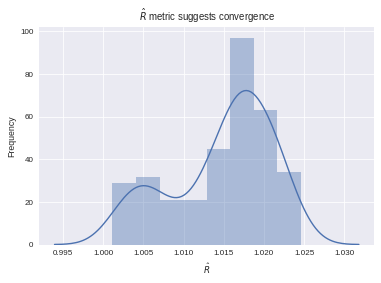

In [189]:
# convergence rhats


with sns.plotting_context('paper'):
    f2 = plt.figure(figsize=(6,4))
    sns.distplot(stan_summary[stan_summary.name.str.startswith('sample2_x')]['R_hat'])
    #plt.title('Unknown mixture fraction estimates -- Rhat distribution')
    plt.title('$\hat{R}$ metric suggests convergence')
    plt.ylabel('Frequency')
    plt.xlabel('$\hat{R}$')
    #f2 = plt.gcf()
    savefig(f2, 'plots/2.1.1/Rhat_sample2-x_dist.pdf', dpi=300)
    savefig(f2, 'plots/2.1.1/Rhat_sample2-x_dist.png', dpi=300)

In [190]:
stan_summary[stan_summary.name.str.startswith('sample2_x')]['R_hat'].describe()

count    130.000000
mean       1.014789
std        0.006226
min        1.001150
25%        1.011338
50%        1.016380
75%        1.019420
max        1.024620
Name: R_hat, dtype: float64

median 168.2415
mean 313.023953846
min 109.903


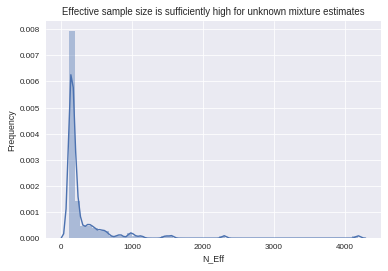

In [191]:
# convergence - N_eff

with sns.plotting_context('paper'):
    f2 = plt.figure(figsize=(6,4)) # 8,6
    sns.distplot(stan_summary[stan_summary.name.str.startswith('sample2_x')]['N_Eff'])
    # Unknown mixture fraction estimates: effective sample size distribution
    plt.title('Effective sample size is sufficiently high for unknown mixture estimates')

    print('median', stan_summary[stan_summary.name.str.startswith('sample2_x')]['N_Eff'].median())
    print('mean', stan_summary[stan_summary.name.str.startswith('sample2_x')]['N_Eff'].mean())
    print('min', stan_summary[stan_summary.name.str.startswith('sample2_x')]['N_Eff'].min())

    plt.ylabel('Frequency')
    #f2 = plt.gcf()
    savefig(f2, 'plots/2.1.1/Neff_sample2-x_dist.pdf', dpi=300)
    savefig(f2, 'plots/2.1.1/Neff_sample2-x_dist.png', dpi=300)

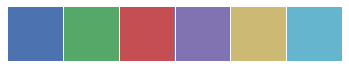

In [192]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

median 0.00119487
mean 0.00179739889231


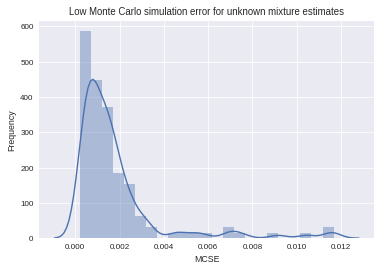

In [193]:
# convergence -- MCSE 
with sns.plotting_context('paper'):
    f2 = plt.figure(figsize=(6,4))
    sns.distplot(stan_summary[stan_summary.name.str.startswith('sample2_x')]['MCSE'],
                 #kde_kws={'color':sns.color_palette()[2]}
                )
    #plt.axvline(x=stan_summary[stan_summary.name.str.startswith('sample2_x')]['MCSE'].median(),
    #            linestyle='dotted', lw=2.5, color=sns.color_palette()[2])
    print('median', stan_summary[stan_summary.name.str.startswith('sample2_x')]['MCSE'].median())
    print('mean', stan_summary[stan_summary.name.str.startswith('sample2_x')]['MCSE'].mean())
    #plt.title('Unknown mixture fraction estimates: Monte Carlo error distribution')
    plt.title('Low Monte Carlo simulation error for unknown mixture estimates')
    plt.ylabel('Frequency')
    #f2 = plt.gcf()
    savefig(f2, 'plots/2.1.1/MCSE_sample2-x_dist.pdf', dpi=300)
    savefig(f2, 'plots/2.1.1/MCSE_sample2-x_dist.png', dpi=300)

median 0.01838675
mean 0.0262134105385


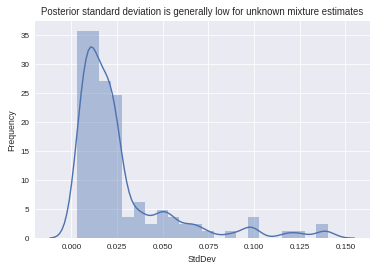

In [194]:
# convergence -- standard deviation
with sns.plotting_context('paper'):
    f2 = plt.figure(figsize=(6,4))
    sns.distplot(stan_summary[stan_summary.name.str.startswith('sample2_x')]['StdDev'])
    # plt.axvline(x=stan_summary[stan_summary.name.str.startswith('sample2_x')]['StdDev'].median(),
    #             linestyle='dotted', lw=2.5, color=sns.color_palette()[2])
    print('median', stan_summary[stan_summary.name.str.startswith('sample2_x')]['StdDev'].median())
    print('mean', stan_summary[stan_summary.name.str.startswith('sample2_x')]['StdDev'].mean())
    plt.title('Posterior standard deviation is generally low for unknown mixture estimates')
    plt.ylabel('Frequency')
    #f2 = plt.gcf()
    savefig(f2, 'plots/2.1.1/StdDev_sample2-x_dist.pdf', dpi=300)
    savefig(f2, 'plots/2.1.1/StdDev_sample2-x_dist.png', dpi=300)

In [195]:
stan_summary[stan_summary.name.str.startswith('sample2_x')]['StdDev'].describe()

count    130.000000
mean       0.026213
std        0.027374
min        0.002823
25%        0.009593
50%        0.018387
75%        0.025939
max        0.140359
Name: StdDev, dtype: float64

# get the full deconvolution distributions

In [185]:
# have to load in the full traces
cols_we_want = stan_summary[stan_summary.name.str.startswith('sample2_x')].name.values
cols_we_want

array(['sample2_x[1,1]', 'sample2_x[1,2]', 'sample2_x[1,3]',
       'sample2_x[1,4]', 'sample2_x[1,5]', 'sample2_x[1,6]',
       'sample2_x[1,7]', 'sample2_x[1,8]', 'sample2_x[1,9]',
       'sample2_x[1,10]', 'sample2_x[1,11]', 'sample2_x[1,12]',
       'sample2_x[1,13]', 'sample2_x[2,1]', 'sample2_x[2,2]',
       'sample2_x[2,3]', 'sample2_x[2,4]', 'sample2_x[2,5]',
       'sample2_x[2,6]', 'sample2_x[2,7]', 'sample2_x[2,8]',
       'sample2_x[2,9]', 'sample2_x[2,10]', 'sample2_x[2,11]',
       'sample2_x[2,12]', 'sample2_x[2,13]', 'sample2_x[3,1]',
       'sample2_x[3,2]', 'sample2_x[3,3]', 'sample2_x[3,4]',
       'sample2_x[3,5]', 'sample2_x[3,6]', 'sample2_x[3,7]',
       'sample2_x[3,8]', 'sample2_x[3,9]', 'sample2_x[3,10]',
       'sample2_x[3,11]', 'sample2_x[3,12]', 'sample2_x[3,13]',
       'sample2_x[4,1]', 'sample2_x[4,2]', 'sample2_x[4,3]',
       'sample2_x[4,4]', 'sample2_x[4,5]', 'sample2_x[4,6]',
       'sample2_x[4,7]', 'sample2_x[4,8]', 'sample2_x[4,9]',
       'samp

In [186]:
cols_we_want_renamed  = [c.replace('[', '.').replace(']', '').replace(',', '.') for c in cols_we_want]
cols_we_want_renamed

['sample2_x.1.1',
 'sample2_x.1.2',
 'sample2_x.1.3',
 'sample2_x.1.4',
 'sample2_x.1.5',
 'sample2_x.1.6',
 'sample2_x.1.7',
 'sample2_x.1.8',
 'sample2_x.1.9',
 'sample2_x.1.10',
 'sample2_x.1.11',
 'sample2_x.1.12',
 'sample2_x.1.13',
 'sample2_x.2.1',
 'sample2_x.2.2',
 'sample2_x.2.3',
 'sample2_x.2.4',
 'sample2_x.2.5',
 'sample2_x.2.6',
 'sample2_x.2.7',
 'sample2_x.2.8',
 'sample2_x.2.9',
 'sample2_x.2.10',
 'sample2_x.2.11',
 'sample2_x.2.12',
 'sample2_x.2.13',
 'sample2_x.3.1',
 'sample2_x.3.2',
 'sample2_x.3.3',
 'sample2_x.3.4',
 'sample2_x.3.5',
 'sample2_x.3.6',
 'sample2_x.3.7',
 'sample2_x.3.8',
 'sample2_x.3.9',
 'sample2_x.3.10',
 'sample2_x.3.11',
 'sample2_x.3.12',
 'sample2_x.3.13',
 'sample2_x.4.1',
 'sample2_x.4.2',
 'sample2_x.4.3',
 'sample2_x.4.4',
 'sample2_x.4.5',
 'sample2_x.4.6',
 'sample2_x.4.7',
 'sample2_x.4.8',
 'sample2_x.4.9',
 'sample2_x.4.10',
 'sample2_x.4.11',
 'sample2_x.4.12',
 'sample2_x.4.13',
 'sample2_x.5.1',
 'sample2_x.5.2',
 'sample2_x.

In [187]:
all_traces = []
for i in range(4):
    print('loading:', i)
    trace_i = pd.read_csv('logs/newmarkergenes_sampling_log.txt_%d.csv' % i, comment='#', usecols=cols_we_want_renamed)
    trace_i['trace_id'] = i
    trace_i['iter'] = trace_i.index
    all_traces.append(trace_i)

loading: 0
loading: 1
loading: 2
loading: 3


In [188]:
all_traces_df = pd.concat(all_traces)
print(all_traces_df.shape)
all_traces_df.head()

(8000, 132)


,sample2_x.1.1,sample2_x.2.1,sample2_x.3.1,sample2_x.4.1,sample2_x.5.1,sample2_x.6.1,sample2_x.7.1,sample2_x.8.1,sample2_x.9.1,sample2_x.10.1,...,sample2_x.3.13,sample2_x.4.13,sample2_x.5.13,sample2_x.6.13,sample2_x.7.13,sample2_x.8.13,sample2_x.9.13,sample2_x.10.13,trace_id,iter
0,0.023568,0.019506,0.273356,0.017382,0.282248,0.114136,0.176982,0.017869,0.230396,0.174504,...,0.01824,0.006905,0.037897,0.02052,0.011482,0.005919,0.002919,0.024678,0,0
1,0.023568,0.019506,0.273356,0.017382,0.282248,0.114136,0.176982,0.017869,0.230396,0.174504,...,0.01824,0.006905,0.037897,0.02052,0.011482,0.005919,0.002919,0.024678,0,1
2,0.023568,0.019506,0.273356,0.017382,0.282248,0.114136,0.176982,0.017869,0.230396,0.174504,...,0.01824,0.006905,0.037897,0.02052,0.011482,0.005919,0.002919,0.024678,0,2
3,0.023568,0.019506,0.273356,0.017382,0.282248,0.114136,0.176982,0.017869,0.230396,0.174504,...,0.01824,0.006905,0.037897,0.02052,0.011482,0.005919,0.002919,0.024678,0,3
4,0.023568,0.019506,0.273356,0.017382,0.282248,0.114136,0.176982,0.017869,0.230396,0.174504,...,0.01824,0.006905,0.037897,0.02052,0.011482,0.005919,0.002919,0.024678,0,4


In [189]:
all_traces_df2 = pd.melt(all_traces_df, id_vars=['iter','trace_id'], value_name='estimate', var_name='variable')
all_traces_df2.head()

,iter,trace_id,variable,estimate
0,0,0,sample2_x.1.1,0.023568
1,1,0,sample2_x.1.1,0.023568
2,2,0,sample2_x.1.1,0.023568
3,3,0,sample2_x.1.1,0.023568
4,4,0,sample2_x.1.1,0.023568


In [190]:
var_ids = all_traces_df2.variable.str.extract('sample2_x.(?P<sample_id>\d+).(?P<subset_id>\d+)')
var_ids.head()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


,sample_id,subset_id
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [191]:
all_traces_df3= pd.concat([all_traces_df2, var_ids], axis=1) 
all_traces_df3.head()

,iter,trace_id,variable,estimate,sample_id,subset_id
0,0,0,sample2_x.1.1,0.023568,1,1
1,1,0,sample2_x.1.1,0.023568,1,1
2,2,0,sample2_x.1.1,0.023568,1,1
3,3,0,sample2_x.1.1,0.023568,1,1
4,4,0,sample2_x.1.1,0.023568,1,1


In [192]:
all_traces_df3['subset_id'] = all_traces_df3['subset_id'].astype(int)
all_traces_df3['sample_id'] = all_traces_df3['sample_id'].astype(int)

In [193]:
sample2_xs = stan_summary[stan_summary.name.str.startswith('sample2_x')]['Mean'].values.reshape(10, 13)
sample2_xs.shape

mixture_estimates = pd.DataFrame(sample2_xs, columns=colnames)
mixture_estimates

import re
subset_names = [re.sub(string=x, pattern='(.*)\[(.*)\]', repl='\\2') for x in mixture_estimates.columns]
subset_names

['B_CD5',
 'B_Memory',
 'B_Naive',
 'CD4_Central_Memory',
 'CD4_Effector_Memory',
 'CD4_Naive',
 'CD4_Th1',
 'CD4_Th17',
 'CD4_Th2',
 'CD4_Treg',
 'CD8_Central_Memory',
 'CD8_Effector',
 'CD8_Naive']

In [194]:
all_traces_df3['subset_name'] = all_traces_df3.subset_id.apply(lambda i: subset_names[i-1])
all_traces_df3.head()

,iter,trace_id,variable,estimate,sample_id,subset_id,subset_name
0,0,0,sample2_x.1.1,0.023568,1,1,B_CD5
1,1,0,sample2_x.1.1,0.023568,1,1,B_CD5
2,2,0,sample2_x.1.1,0.023568,1,1,B_CD5
3,3,0,sample2_x.1.1,0.023568,1,1,B_CD5
4,4,0,sample2_x.1.1,0.023568,1,1,B_CD5


In [195]:
# IMPORTANT: drop the warmup samples!!!!!
warmup = 1000
# this should show a wide range
#all_traces_df3.iter.hist()
all_traces_df3.iter.describe()[['min', 'max']]

min       0.0
max    1999.0
Name: iter, dtype: float64

In [196]:
# drop warmups
all_traces_df3 = all_traces_df3.loc[all_traces_df3['iter']>=1000,]
all_traces_df3['iter'] -= 1000
# this should be better now
#all_traces_df3.iter.hist()
all_traces_df3.iter.describe()[['min', 'max']]

min      0.0
max    999.0
Name: iter, dtype: float64

In [197]:
# combine iteration numbers across traces -- i.e. line them up from 0 to 4000, not 4 versions of 0 to 1000
#(all_traces_df3['trace_id']*1000 + all_traces_df3['iter']).hist()
(all_traces_df3['trace_id']*1000 + all_traces_df3['iter']).describe()[['min', 'max']]

min       0.0
max    3999.0
dtype: float64

In [198]:
all_traces_df3['combined_iter_number'] = (all_traces_df3['trace_id']*1000 + all_traces_df3['iter'])

In [199]:
assert all_traces_df3.shape[0] / 10 / 13 / 4 == 1000.

# Plot

In [200]:
friendly_mixture_descriptions = [
    '50% Naive B cell, 50% Memory B cell',
    '50% Naive B cell, 50% Memory B cell (2)',
    '25% Naive B cell, 75% Memory B cell',
    '25% Naive B cell, 75% Memory B cell (2)',
    '75% Naive B cell, 25% Memory B cell',
    '75% Naive B cell, 25% Memory B cell (2)',
    '50% Naive B cell, 50% CD4 Treg cell',
    '25% Naive B cell, 75% CD4 Treg cell',
    '50% Naive B cell, 50% CD4 Treg cell (2)',
    '25% Naive B cell, 75% CD4 Treg cell (2)',
]
len(friendly_mixture_descriptions)

10

In [231]:
# TODO

friendly_mixture_descriptions2 = [
    'Some raw samples are harder to deconvolve',
    'Naive, memory B cells hard to separate in direct comparison',
    'Model consistently prefers naive to memory B cells',
    'Drop',
    'Drop',
    'Drop',
    'Simple mixture: 50% naive B cell, 50% CD4+ Treg cell samples.', #'B and T cell supertypes are well differentiated',
    'Drop',
    'Model confuses naive and memory B cells when differentiating from T cells',
    'Model underestimates regulatory T cells',
]
rollup9of10 = 'Model properly estimates at higher level of hierarchy'
rollup1of10 = 'Complex mixture: 50% naive, 50% memory B cell samples -- rolled up.'

len(friendly_mixture_descriptions2)


10

In [202]:
import matplotlib.ticker as ticker
sns.set_context('paper')
sns.set_style("darkgrid")

In [220]:
example_result[cib_class_names].iloc[0]

B_CD5                  0.051578
B_Memory               0.459352
B_Naive                0.222262
CD4_Central_Memory     0.000000
CD4_Effector_Memory    0.000000
CD4_Naive              0.034986
CD4_Th1                0.060086
CD4_Th17               0.033509
CD4_Th2                0.000000
CD4_Treg               0.027812
CD8_Central_Memory     0.000000
CD8_Effector           0.110415
CD8_Naive              0.000000
Name: 0, dtype: float64

In [250]:
sns.axes_style()['axes.linewidth']

0.0

In [203]:
# Custom legend
# Via Seaborn and https://matplotlib.org/users/legend_guide.html


# modifications from seaborn source:
# https://github.com/mwaskom/seaborn/blob/5ba1e2c7e3b32919a3c9ce1b411f2025ff8fc09e/seaborn/categorical.py


# # Determine the gray color to use for the lines framing the plot
# light_vals = [colorsys.rgb_to_hls(*c)[1] for c in rgb_colors]
# l = min(light_vals) * .6
# gray = mpl.colors.rgb2hex((l, l, l))

# add_legend_data(ax) -- original use in seaborn src
def add_legend_data_point(ax, rgb, label):
    """Add empty scatterplot artists with labels for the legend."""
    ax.scatter([], [], color=mpl.colors.rgb2hex(rgb), label=label, s=60)
#     if self.hue_names is not None:
#         for rgb, label in zip(self.colors, self.hue_names):
#             ax.scatter([], [],
#                        color=mpl.colors.rgb2hex(rgb),
#                        label=label,
#                        s=60)


# add_legend_data(ax, self.colors[j], hue_level) -- original use in seaborn src
def add_legend_data_bar(ax, color, label, linewidth=0.0):
    """Add a dummy patch object so we can get legend data."""
    rect = plt.Rectangle([0, 0], 0, 0,
                         linewidth=linewidth / 2,
                         #edgecolor=self.gray,
                         edgecolor='gray',
                         facecolor=color,
                         label=label)
    ax.add_patch(rect)

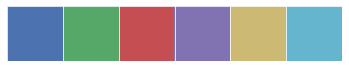

In [257]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

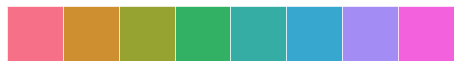

In [259]:
sns.palplot(sns.color_palette("husl", 8))

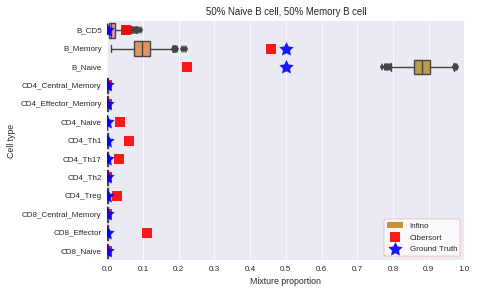

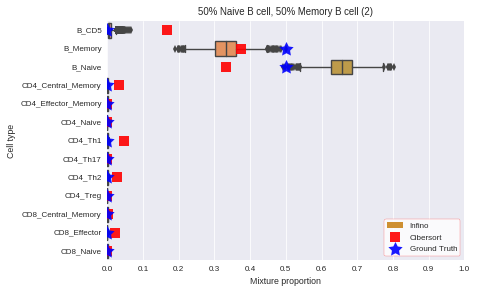

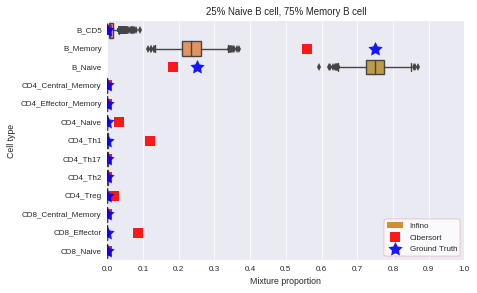

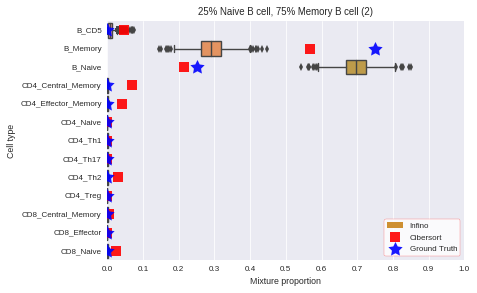

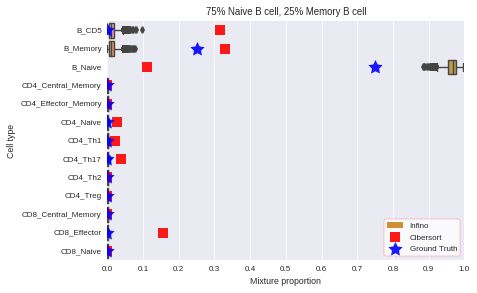

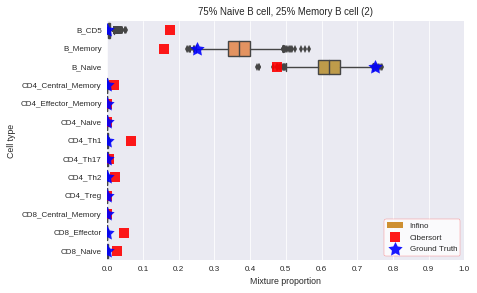

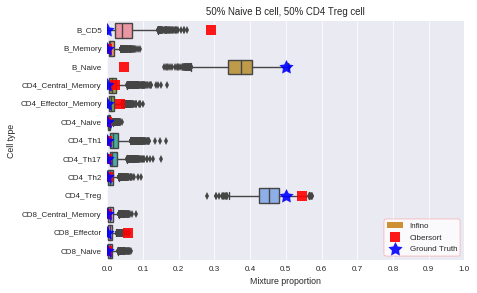

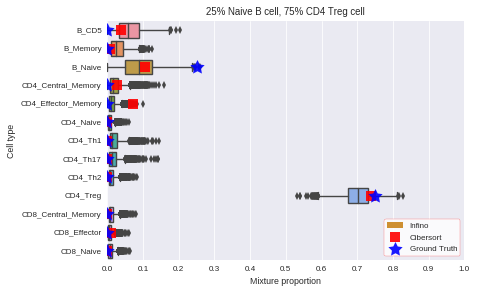

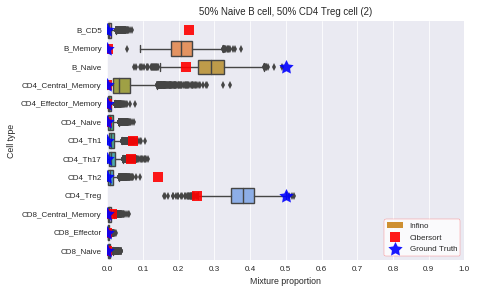

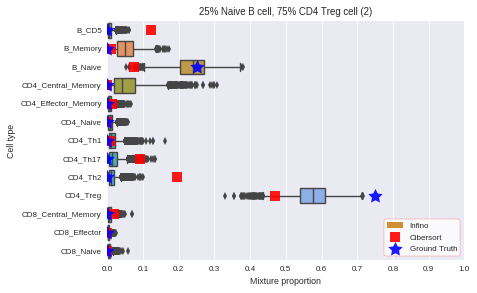

In [285]:
# Plot with just the descriptions of the mixtures.
# And overlay Cibersort.

for (key, grp), (_, groundtruth), friendly_title, (_, cib_vals) in zip(all_traces_df3.groupby('sample_id'),
                                                                        stan_data['x2'].iterrows(),
                                                                        friendly_mixture_descriptions,
                                                                        example_result[cib_class_names].iterrows()
                                                                       ):
    f = plt.figure()
    g = sns.boxplot(data=grp, y='subset_name', x='estimate',
                    #hue='subset_name', # this adds to legend but screws up the plot
#                    label='Infino', # this doesn't work for boxplots
                   )
    #g.set_title('mixture %d' % key)
    g.set_title(friendly_title)    
    g.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    
    # add infino boxplots to legend manually
    add_legend_data_bar(plt.gca(),
                        #current_palette[4],
                        sns.color_palette("husl", 8)[1],
                        'Infino')
    
    
    # add cibersort points
    cb = pd.DataFrame(cib_vals).reset_index()
    cb.columns = ['SubSet', 'estimate']
    sns.stripplot(x="estimate", y="SubSet", data=cb,
                 linewidth=0,
                 size=15,
                 color='r',
                 alpha=.9,
                 marker=(4,0, 45),
                  label='Cibersort',
                 )
    
    # add groundtruth points
    gt = groundtruth.copy()
    gt.index = [s.replace('SubSet[', '').replace(']', '') for s in gt.index]
    gt = pd.DataFrame(gt).reset_index()
    gt.columns = ['SubSet', 'estimate']
    #print(gt)
    sns.stripplot(x="estimate", y="SubSet", data=gt,
                  linewidth=0,
                  #jitter=True,
                  #size=3,
                  #color=".3",
                  size=15,
                  #color="r",
                  color='b',
                  alpha=.9,
                  #marker="*",
                  #marker='P',
                  marker=(5, 1),
                  label='Ground Truth',
                 )
    

    
    # give the stars a border
    # and this will set the star color to the row's color
#     sns.stripplot(x="estimate", y="SubSet", data=gt,
#                 size=18,
#                 facecolors='none',
#                   #fillstyle='none',
#                 edgecolor='r',
#                 split=False,
#                   alpha=0.7
#                  )

    
    
    g.set_xlabel('Mixture proportion')
    g.set_ylabel('Cell type')
    g.set_xbound(0,1)
    
    # show legend, and subselect because stripplot adds one legend item per point it appears
    #plt.legend(loc='lower right') # loc='best'
    handles, labels = plt.gca().get_legend_handles_labels()
    legend = plt.gca().legend([handles[0], handles[1], handles[-1]],
                     [labels[0], labels[1], labels[-1]],
#                      loc='best',
                     loc='lower right',
                     frameon=True
                    )
    frame = legend.get_frame()
    frame.set_edgecolor('red')
    frame.set_facecolor('white')
    
    savefig(f, 'plots/2.1.1/mixture%d.png' % key, dpi=300)
    savefig(f, 'plots/2.1.1/mixture%d.pdf' % key, dpi=300)
    #break

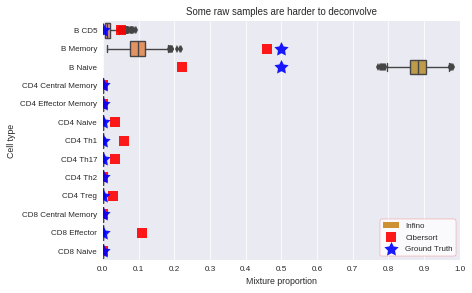

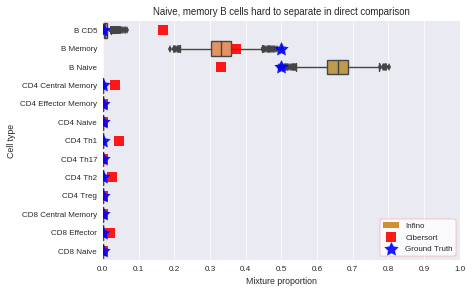

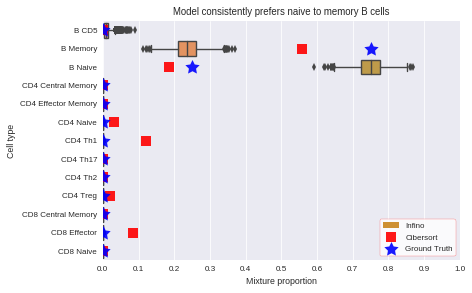

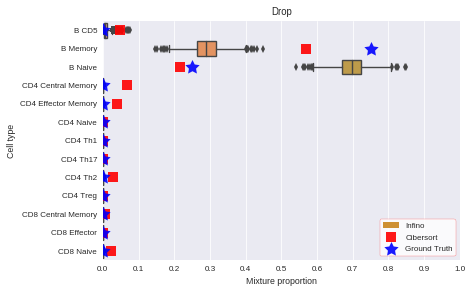

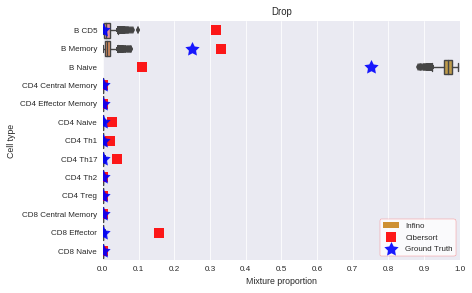

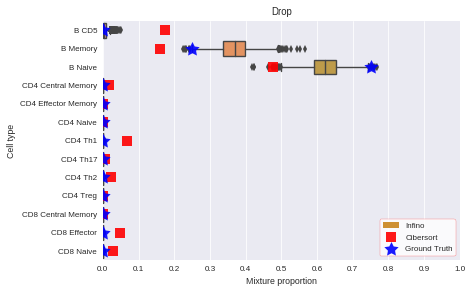

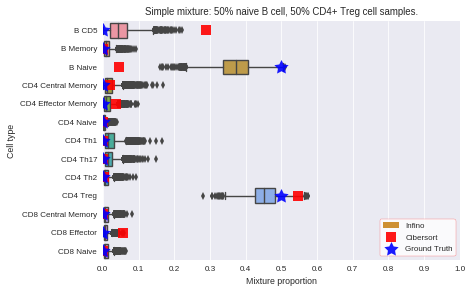

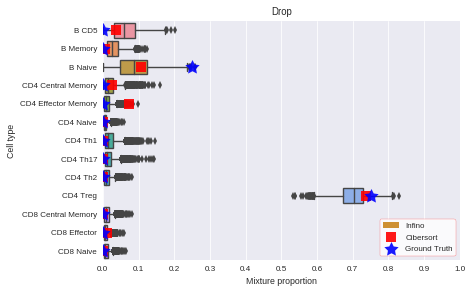

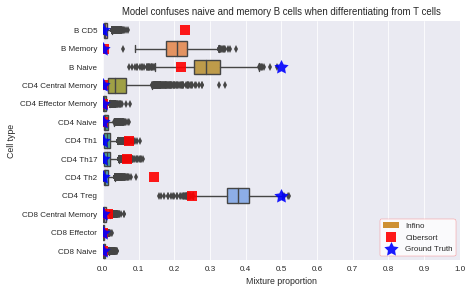

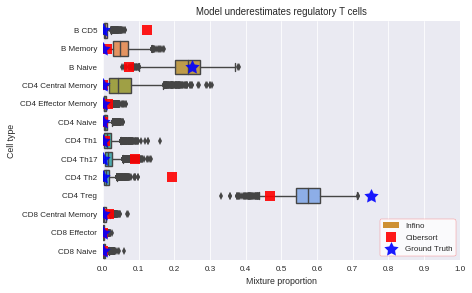

In [217]:
# Plot cleaner and friendly names.

cleaner_traces = all_traces_df3.copy()
cleaner_traces['subset_name'] = cleaner_traces['subset_name'].str.replace('_', ' ')
cleaner_traces['subset_name'].value_counts()

cleaner_gt = stan_data['x2'].rename(columns = lambda x: x.replace('_', ' ').replace('SubSet[', '').replace(']', ''))
cleaner_gt.columns


for (key, grp), (_, groundtruth), friendly_title, (_, cib_vals) in zip(cleaner_traces.groupby('sample_id'), # all_traces_df3
                                                                      cleaner_gt.iterrows(), # stan_data['x2']
                                                                      friendly_mixture_descriptions2,
                                                                      example_result[cib_class_names].iterrows()
                                                                     ):
    f = plt.figure()
    g = sns.boxplot(data=grp, y='subset_name', x='estimate')
    #g.set_title('mixture %d' % key)
    g.set_title(friendly_title)    
    g.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    
    # add infino boxplots to legend manually
    add_legend_data_bar(plt.gca(),
                        #current_palette[4],
                        sns.color_palette("husl", 8)[1],
                        'Infino')
    
    
    # add cibersort points
    cb = pd.DataFrame(cib_vals).reset_index()
    cb.columns = ['SubSet', 'estimate']
    sns.stripplot(x="estimate", y="SubSet", data=cb,
                 linewidth=0,
                 size=15,
                 color='r',
                 alpha=.9,
                 marker=(4,0, 45),
                  label='Cibersort',
                 )
    
    # add groundtruth points
    gt = groundtruth.copy()
    #gt.index = [s.replace('SubSet[', '').replace(']', '') for s in gt.index]
    gt = pd.DataFrame(gt).reset_index()
    gt.columns = ['SubSet', 'estimate']
    #print(gt)
    sns.stripplot(x="estimate", y="SubSet", data=gt,
                  linewidth=0,
                  #jitter=True,
                  #size=3,
                  #color=".3",
                  size=15,
                  #color="r",
                  color='b',
                  alpha=.9,
                  #marker="*",
                  marker=(5, 1),
                  label='Ground Truth'
                 )
    
    # give the stars a border
    # and this will set the star color to the row's color
#     sns.stripplot(x="estimate", y="SubSet", data=gt,
#                 size=18,
#                 facecolors='none',
#                   #fillstyle='none',
#                 edgecolor='r',
#                 split=False,
#                   alpha=0.7
#                  )

    
    
    g.set_xlabel('Mixture proportion')
    g.set_ylabel('Cell type')
    g.set_xbound(0,1)
    
    # show legend, and subselect because stripplot adds one legend item per point it appears
    #plt.legend(loc='lower right') # loc='best'
    handles, labels = plt.gca().get_legend_handles_labels()
    legend = plt.gca().legend([handles[0], handles[1], handles[-1]],
                     [labels[0], labels[1], labels[-1]],
#                      loc='best',
                     loc='lower right',
                     frameon=True
                    )
    frame = legend.get_frame()
    frame.set_edgecolor('red')
    frame.set_facecolor('white')


    
    savefig(f, 'plots/2.1.1/mixture%d.cleaner2.png' % key, dpi=300)
    savefig(f, 'plots/2.1.1/mixture%d.cleaner2.pdf' % key, dpi=300)
    #break

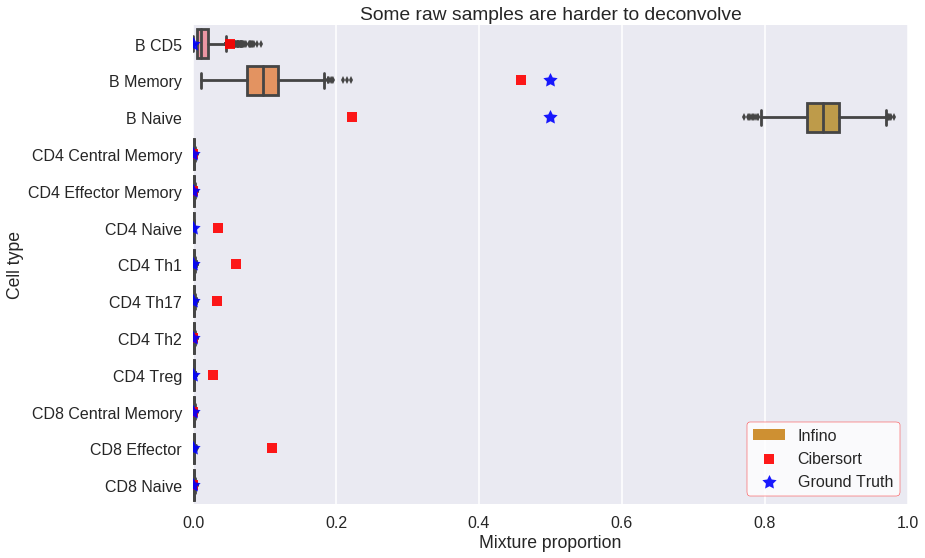

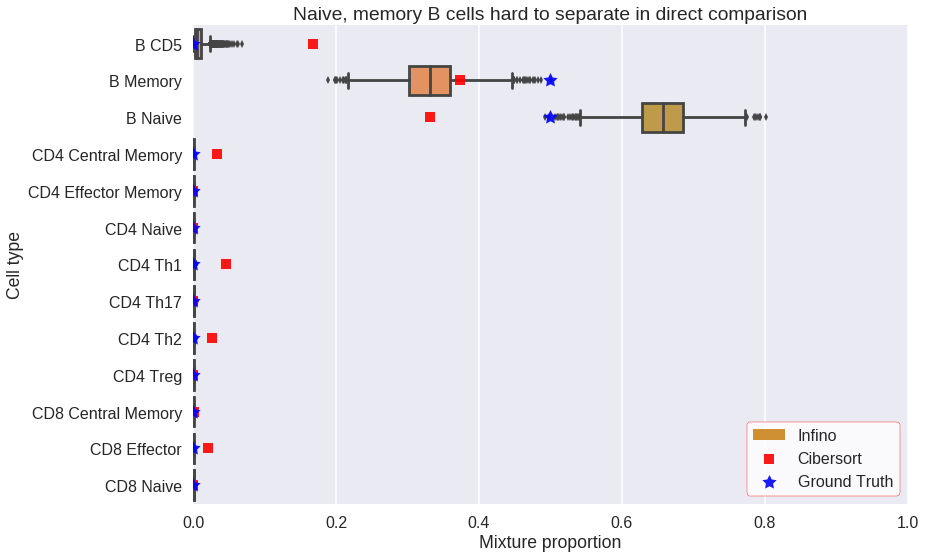

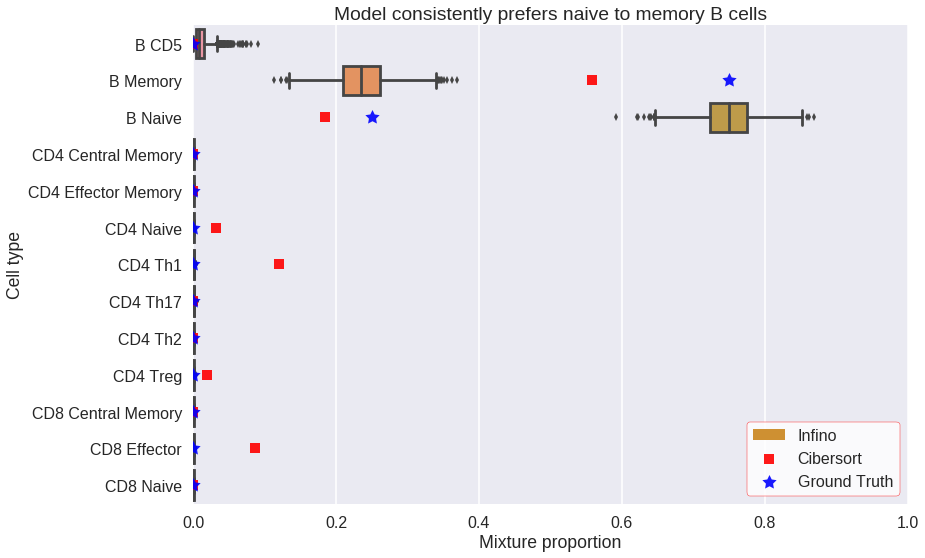

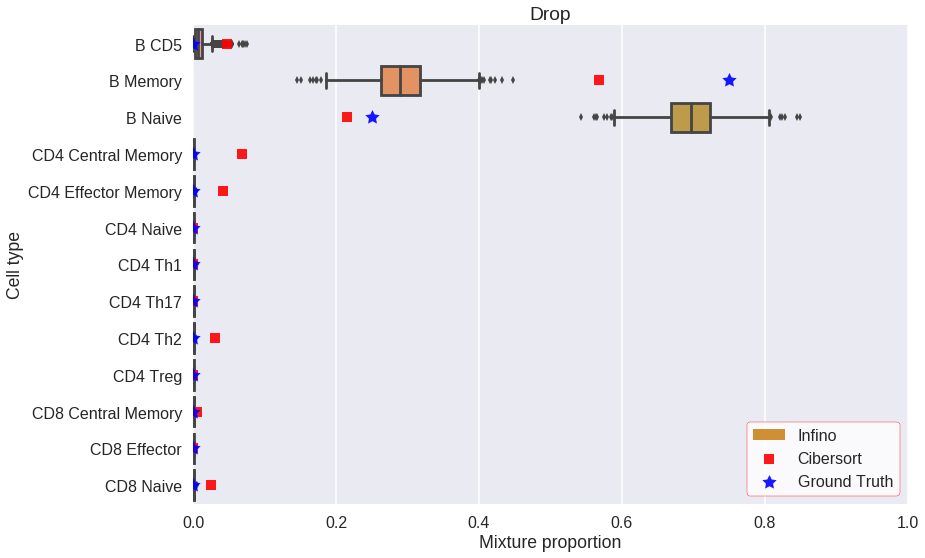

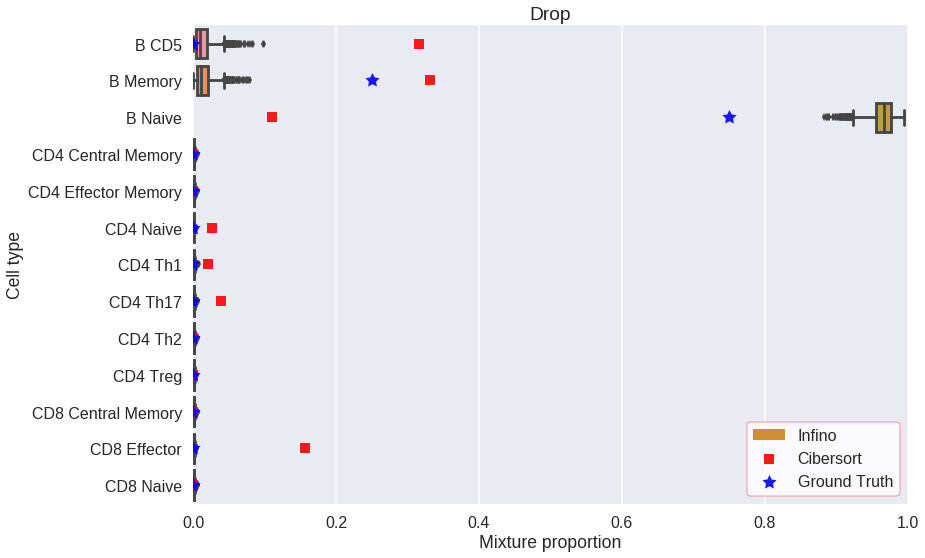

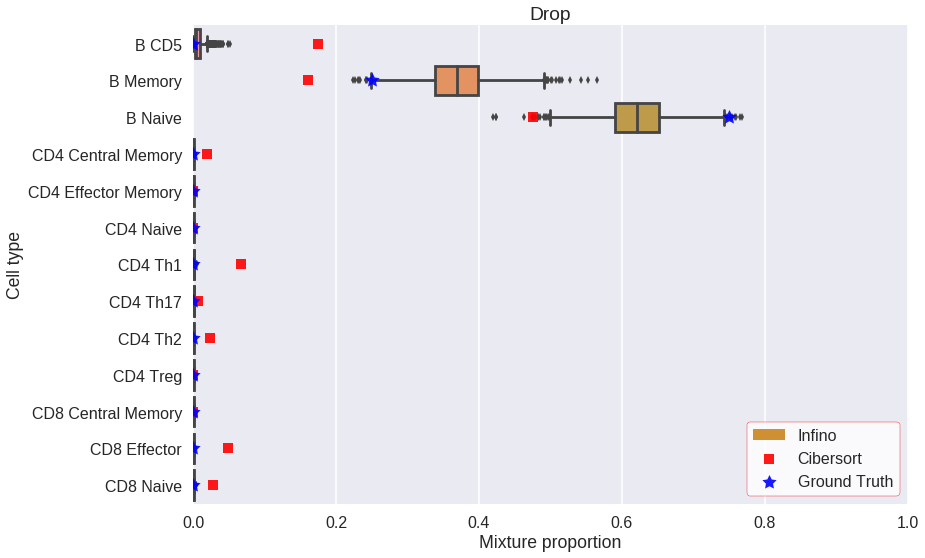

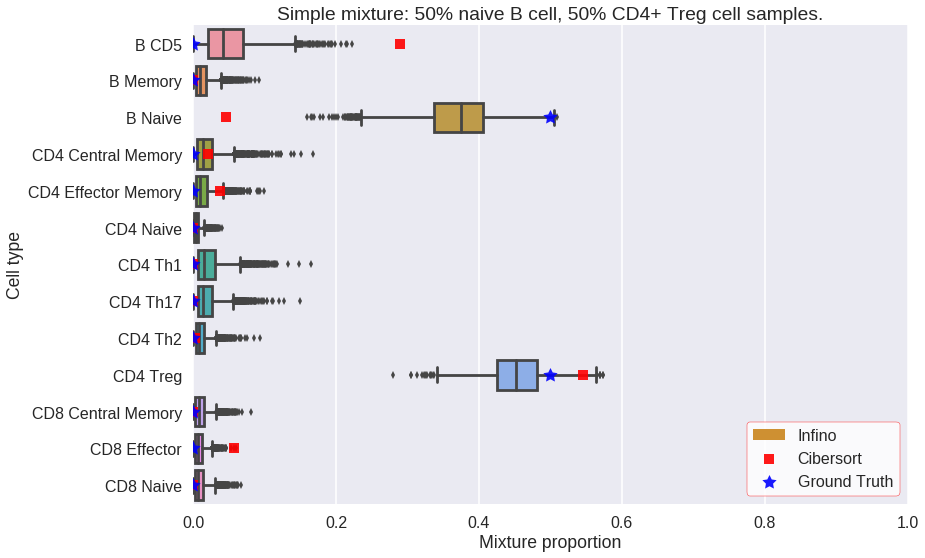

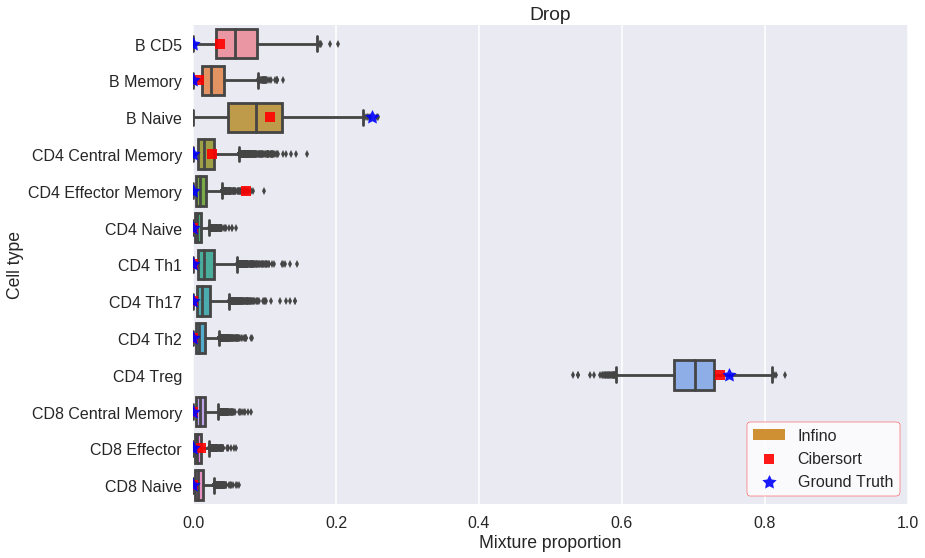

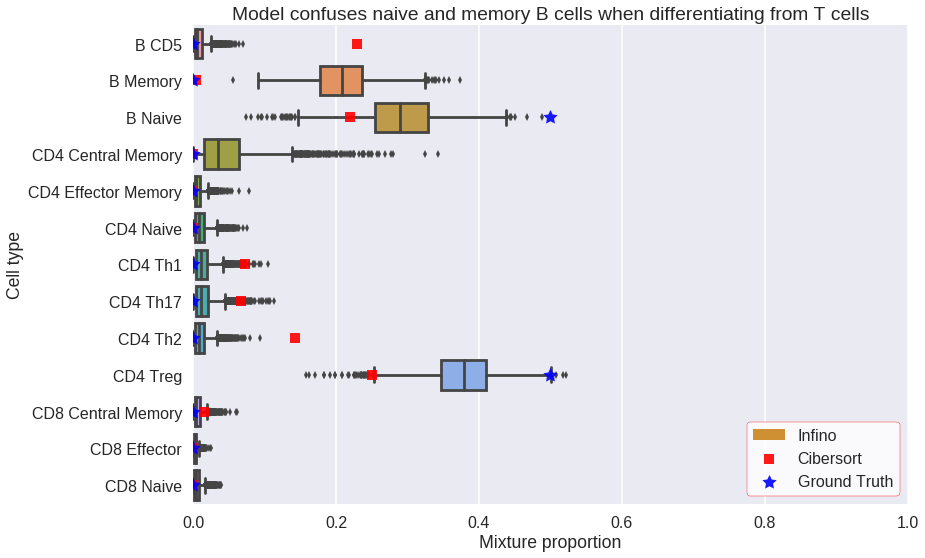

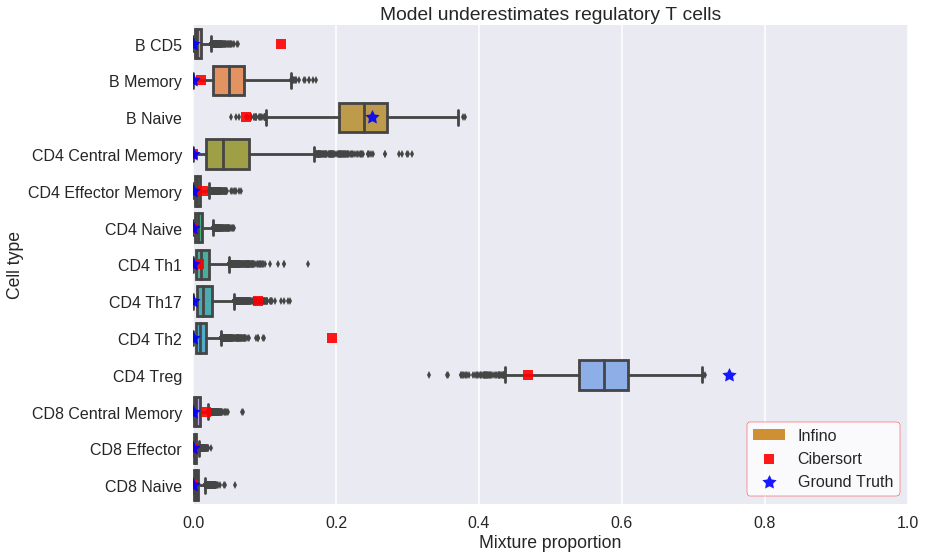

In [245]:
# Plot cleaner and friendly names.
# POSTER ONLY

cleaner_traces = all_traces_df3.copy()
cleaner_traces['subset_name'] = cleaner_traces['subset_name'].str.replace('_', ' ')
cleaner_traces['subset_name'].value_counts()

cleaner_gt = stan_data['x2'].rename(columns = lambda x: x.replace('_', ' ').replace('SubSet[', '').replace(']', ''))
cleaner_gt.columns

with sns.plotting_context('poster'):
    for (key, grp), (_, groundtruth), friendly_title, (_, cib_vals) in zip(cleaner_traces.groupby('sample_id'), # all_traces_df3
                                                                          cleaner_gt.iterrows(), # stan_data['x2']
                                                                          friendly_mixture_descriptions2,
                                                                          example_result[cib_class_names].iterrows()
                                                                         ):
        f = plt.figure()
        g = sns.boxplot(data=grp, y='subset_name', x='estimate')
        #g.set_title('mixture %d' % key)
        g.set_title(friendly_title)    
        
        #g.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
        g.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

        # add infino boxplots to legend manually
        add_legend_data_bar(plt.gca(),
                            #current_palette[4],
                            sns.color_palette("husl", 8)[1],
                            'Infino')


        # add cibersort points
        cb = pd.DataFrame(cib_vals).reset_index()
        cb.columns = ['SubSet', 'estimate']
        sns.stripplot(x="estimate", y="SubSet", data=cb,
                     linewidth=0,
                     size=15,
                     color='r',
                     alpha=.9,
                     marker=(4,0, 45),
                      label='Cibersort',
                     )

        # add groundtruth points
        gt = groundtruth.copy()
        #gt.index = [s.replace('SubSet[', '').replace(']', '') for s in gt.index]
        gt = pd.DataFrame(gt).reset_index()
        gt.columns = ['SubSet', 'estimate']
        #print(gt)
        sns.stripplot(x="estimate", y="SubSet", data=gt,
                      linewidth=0,
                      #jitter=True,
                      #size=3,
                      #color=".3",
                      size=15,
                      #color="r",
                      color='b',
                      alpha=.9,
                      #marker="*",
                      marker=(5, 1),
                      label='Ground Truth'
                     )

        # give the stars a border
        # and this will set the star color to the row's color
    #     sns.stripplot(x="estimate", y="SubSet", data=gt,
    #                 size=18,
    #                 facecolors='none',
    #                   #fillstyle='none',
    #                 edgecolor='r',
    #                 split=False,
    #                   alpha=0.7
    #                  )



        g.set_xlabel('Mixture proportion')
        g.set_ylabel('Cell type')
        g.set_xbound(0,1)

        # show legend, and subselect because stripplot adds one legend item per point it appears
        #plt.legend(loc='lower right') # loc='best'
        handles, labels = plt.gca().get_legend_handles_labels()
        legend = plt.gca().legend([handles[0], handles[1], handles[-1]],
                         [labels[0], labels[1], labels[-1]],
    #                      loc='best',
                         loc='lower right',
                         frameon=True
                        )
        frame = legend.get_frame()
        frame.set_edgecolor('red')
        frame.set_facecolor('white')



        savefig(f, 'plots/2.1.1/mixture%d.cleaner2.PORTRAIT.png' % key, dpi=300)
        savefig(f, 'plots/2.1.1/mixture%d.cleaner2.PORTRAIT.pdf' % key, dpi=300)
        #break

# Plot rollups

In [204]:
subset_names, cib_class_names

(['B_CD5',
  'B_Memory',
  'B_Naive',
  'CD4_Central_Memory',
  'CD4_Effector_Memory',
  'CD4_Naive',
  'CD4_Th1',
  'CD4_Th17',
  'CD4_Th2',
  'CD4_Treg',
  'CD8_Central_Memory',
  'CD8_Effector',
  'CD8_Naive'],
 ['B_CD5',
  'B_Memory',
  'B_Naive',
  'CD4_Central_Memory',
  'CD4_Effector_Memory',
  'CD4_Naive',
  'CD4_Th1',
  'CD4_Th17',
  'CD4_Th2',
  'CD4_Treg',
  'CD8_Central_Memory',
  'CD8_Effector',
  'CD8_Naive'])

In [205]:
# # Roll up by cell type

rollups = {
    'B': subset_names[:3],
    'CD4 T': subset_names[3:10],
    'CD8 T': subset_names[10:]
}
rollups = {
    'B': [c for c in cib_class_names if c.startswith('B_')],
    'CD4 T': [c for c in cib_class_names if c.startswith('CD4_')],
    'CD8 T': [c for c in cib_class_names if c.startswith('CD8_')]
}
rollups

{'B': ['B_CD5', 'B_Memory', 'B_Naive'],
 'CD4 T': ['CD4_Central_Memory',
  'CD4_Effector_Memory',
  'CD4_Naive',
  'CD4_Th1',
  'CD4_Th17',
  'CD4_Th2',
  'CD4_Treg'],
 'CD8 T': ['CD8_Central_Memory', 'CD8_Effector', 'CD8_Naive']}

In [206]:
def label_rollup(rollups, x):
    for key in rollups.keys():
        if x in rollups[key]:
            return key
    return None

In [207]:
all_traces_df3['rollup'] = all_traces_df3.subset_name.apply(lambda x: label_rollup(rollups, x))

all_traces_df3.rollup.value_counts()

CD4 T    280000
B        120000
CD8 T    120000
Name: rollup, dtype: int64

In [219]:
samples_rolledup = all_traces_df3.groupby(['sample_id', 'combined_iter_number', 'rollup']).estimate.sum().reset_index()
samples_rolledup.head()

,sample_id,combined_iter_number,rollup,estimate
0,1,0,B,0.994511
1,1,0,CD4 T,0.004095
2,1,0,CD8 T,0.001394
3,1,1,B,0.995181
4,1,1,CD4 T,0.003383


In [220]:
# now roll up ground truth: sum the subset fractions for every sample into B, CD8 T, CD4 groups:

groundtruth_df = stan_data['x2'].copy()
groundtruth_df['mixID'] = range(len(groundtruth_df))
groundtruth_df

,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive],mixID
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,2
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,3
0,0.0,0.25,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,4
0,0.0,0.25,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,5
0,0.0,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0,6
0,0.0,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,7
0,0.0,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0,8
0,0.0,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,9


In [221]:
groundtruth_df_2 = pd.melt(groundtruth_df, id_vars=['mixID'], var_name='subset', value_name='estimate')
print(groundtruth_df_2.shape)
groundtruth_df_2['subset'] = groundtruth_df_2['subset'].apply(lambda x: re.sub(string=x, pattern='(.*)\[(.*)\]', repl='\\2'))
groundtruth_df_2['rollup'] = groundtruth_df_2.subset.apply(lambda x: label_rollup(rollups, x))
groundtruth_df_2.head()

(130, 3)


,mixID,subset,estimate,rollup
0,0,B_CD5,0.0,B
1,1,B_CD5,0.0,B
2,2,B_CD5,0.0,B
3,3,B_CD5,0.0,B
4,4,B_CD5,0.0,B


In [222]:
rollup_groundtruth = groundtruth_df_2.groupby(['mixID', 'rollup']).estimate.sum().reset_index()
rollup_groundtruth.head()

,mixID,rollup,estimate
0,0,B,1.0
1,0,CD4 T,0.0
2,0,CD8 T,0.0
3,1,B,1.0
4,1,CD4 T,0.0


In [223]:
# cibersort results
rollupsums_df.head()

,B,CD4 T,CD8 T
0,0.733192,0.156393,0.110415
1,0.873172,0.104869,0.021959
2,0.742666,0.171586,0.085748
3,0.831617,0.139056,0.029327
4,0.756919,0.086678,0.156404


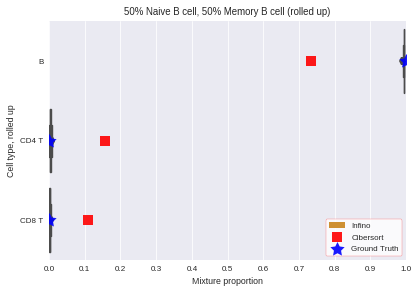

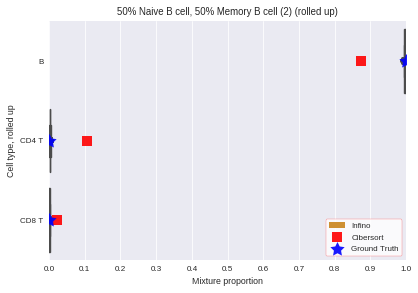

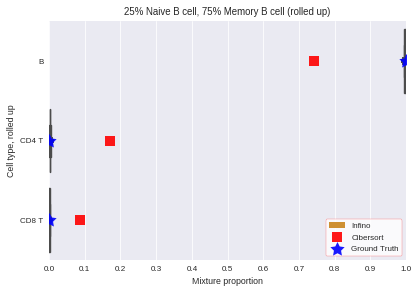

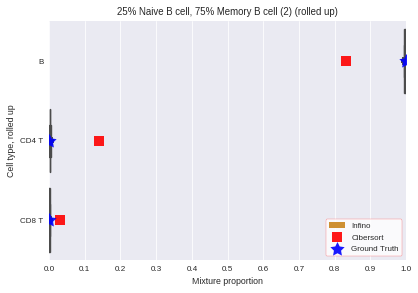

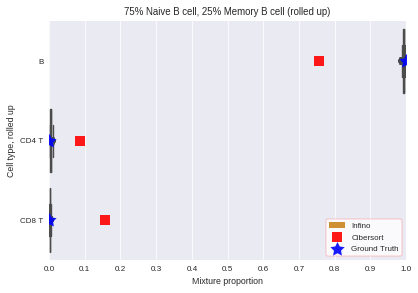

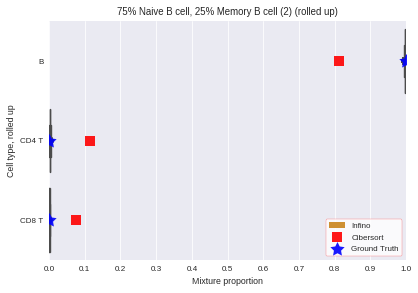

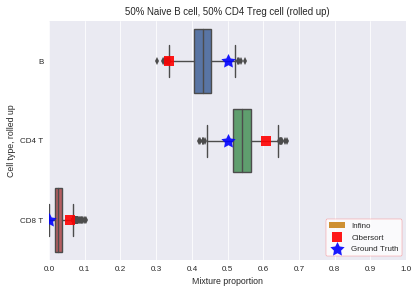

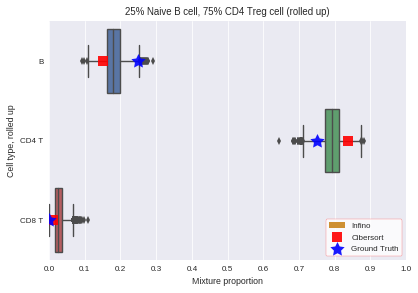

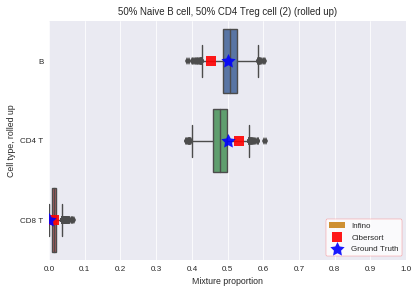

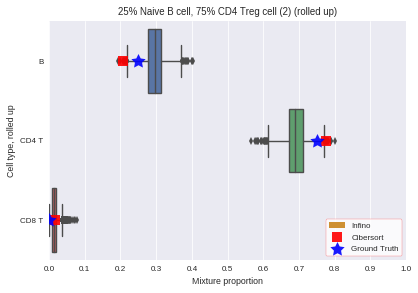

In [306]:
# Plot all rollups.

for (key, grp), (mixID, groundtruth), friendly_title, (_, cib_vals) in zip(samples_rolledup.groupby('sample_id'),
                                                                          rollup_groundtruth.groupby('mixID'),
                                                                          friendly_mixture_descriptions,
                                                                          rollupsums_df.iterrows()
                                                                         ):
    f = plt.figure()
    #g = sns.boxplot(data=grp, y='subset_name', x='estimate')
    g = sns.boxplot(data=grp, y='rollup', x='estimate')
    #g.set_title('mixture %d' % key)
    g.set_title(friendly_title + ' (rolled up)')    
    g.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    
    # add infino boxplots to legend manually
    add_legend_data_bar(plt.gca(),
                        #current_palette[4],
                        sns.color_palette("husl", 8)[1],
                        'Infino')
    
    
    # add cibersort points
    cb = pd.DataFrame(cib_vals).reset_index()
    cb.columns = ['rollup', 'estimate']
    sns.stripplot(x="estimate", y="rollup", data=cb,
                 linewidth=0,
                 size=15,
                 color='r',
                 alpha=.9,
                 marker=(4,0, 45),
                  label='Cibersort',
                 )
    
    # add groundtruth points
    sns.stripplot(x="estimate", y="rollup", data=groundtruth,
                  linewidth=0,
                  #jitter=True,
                  #size=3,
                  #color=".3",
                  size=15,
                  #color="r",
                  color='b',
                  alpha=.9,
                  #marker="*",
                  marker=(5, 1),
                  label='Ground Truth',
                 )
    
    g.set_xlabel('Mixture proportion')
    g.set_ylabel('Cell type, rolled up')
    g.set_xbound(0,1)
    
    # show legend, and subselect because stripplot adds one legend item per point it appears
    #plt.legend(loc='lower right') # loc='best'
    handles, labels = plt.gca().get_legend_handles_labels()
    legend = plt.gca().legend([handles[0], handles[1], handles[-1]],
                     [labels[0], labels[1], labels[-1]],
#                      loc='best',
                     loc='lower right',
                     frameon=True
                    )
    frame = legend.get_frame()
    frame.set_edgecolor('red')
    frame.set_facecolor('white')
    
    savefig(f, 'plots/2.1.1/mixture%d.rollup.png' % key, dpi=300)
    savefig(f, 'plots/2.1.1/mixture%d.rollup.pdf' % key, dpi=300)
    #break

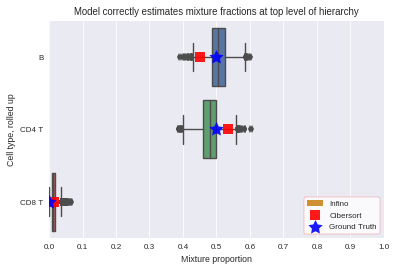

In [312]:
# plot one rollup with better title

rollup9of10 = 'Model correctly estimates mixture fractions at top level of hierarchy'

with sns.plotting_context('paper'):
    for (key, grp), \
    (mixID, groundtruth), \
    friendly_title, \
    cib_vals in zip(samples_rolledup[samples_rolledup['sample_id'] == 9].groupby('sample_id'),
                         rollup_groundtruth[rollup_groundtruth['mixID'] == 8].groupby('mixID'),
                         [rollup9of10],
                         [rollupsums_df.iloc[8]]
                        ):
        f = plt.figure(figsize=(6,4))
        #g = sns.boxplot(data=grp, y='subset_name', x='estimate')
        g = sns.boxplot(data=grp, y='rollup', x='estimate')
        #g.set_title('mixture %d' % key)
        g.set_title(friendly_title) # + ' (rolled up)')    
        g.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
        
        # add infino boxplots to legend manually
        add_legend_data_bar(plt.gca(),
                        #current_palette[4],
                        sns.color_palette("husl", 8)[1],
                        'Infino')
        
        # add cibersort points
        cb = pd.DataFrame(cib_vals).reset_index()
        cb.columns = ['rollup', 'estimate']
        sns.stripplot(x="estimate", y="rollup", data=cb,
                     linewidth=0,
                     size=15,
                     color='r',
                     alpha=.9,
                     marker=(4,0, 45),
                      label='Cibersort',
                     )

        # add groundtruth points
        sns.stripplot(x="estimate", y="rollup", data=groundtruth,
                      linewidth=0,
                      #jitter=True,
                      #size=3,
                      #color=".3",
                      size=15,
                      #color="r",
                      color='b',
                      alpha=.9,
                      #marker="*",
                      marker=(5, 1),
                      label='Ground Truth',
                     )

        g.set_xlabel('Mixture proportion')
        g.set_ylabel('Cell type, rolled up')
        g.set_xbound(0,1)
        
        # show legend, and subselect because stripplot adds one legend item per point it appears
        #plt.legend(loc='lower right') # loc='best'
        handles, labels = plt.gca().get_legend_handles_labels()
        legend = plt.gca().legend([handles[0], handles[1], handles[-1]],
                         [labels[0], labels[1], labels[-1]],
    #                      loc='best',
                         loc='lower right',
                         frameon=True
                        )
        frame = legend.get_frame()
        frame.set_edgecolor('red')
        frame.set_facecolor('white')

        savefig(f, 'plots/2.1.1/mixture%d.cleaner2.rollup.png' % key, dpi=300)
        savefig(f, 'plots/2.1.1/mixture%d.cleaner2.rollup.pdf' % key, dpi=300)
        break

Complex mixture: 50% naive, 50% memory B cell samples -- rolled up.
key and filename (1-indexed):  1
mixid (0-indexed):  0


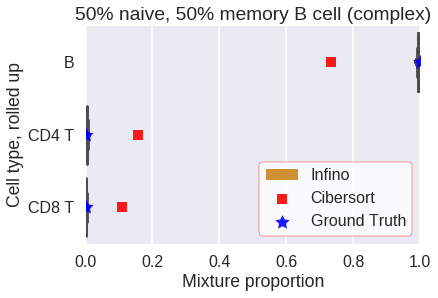

In [243]:
# plot one rollup with better title
# FOR POSTER ONLY!

print(rollup1of10)
rollup1of10_shorter = '50% naive, 50% memory B cell (complex)'

with sns.plotting_context('poster'):
    for (key, grp), \
    (mixID, groundtruth), \
    friendly_title, \
    cib_vals in zip(samples_rolledup[samples_rolledup['sample_id'] == 1].groupby('sample_id'),
                         rollup_groundtruth[rollup_groundtruth['mixID'] == 0].groupby('mixID'),
                         [rollup1of10_shorter],
                         [rollupsums_df.iloc[0]]
                        ):
        f = plt.figure(figsize=(6,4))
        #g = sns.boxplot(data=grp, y='subset_name', x='estimate')
        g = sns.boxplot(data=grp, y='rollup', x='estimate')
        #g.set_title('mixture %d' % key)
        g.set_title(friendly_title) # + ' (rolled up)')    
        #g.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
        g.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
        
        # add infino boxplots to legend manually
        add_legend_data_bar(plt.gca(),
                        #current_palette[4],
                        sns.color_palette("husl", 8)[1],
                        'Infino')
        
        # add cibersort points
        cb = pd.DataFrame(cib_vals).reset_index()
        cb.columns = ['rollup', 'estimate']
        sns.stripplot(x="estimate", y="rollup", data=cb,
                     linewidth=0,
                     size=15,
                     color='r',
                     alpha=.9,
                     marker=(4,0, 45),
                      label='Cibersort',
                     )

        # add groundtruth points
        sns.stripplot(x="estimate", y="rollup", data=groundtruth,
                      linewidth=0,
                      #jitter=True,
                      #size=3,
                      #color=".3",
                      size=15,
                      #color="r",
                      color='b',
                      alpha=.9,
                      #marker="*",
                      marker=(5, 1),
                      label='Ground Truth',
                     )

        g.set_xlabel('Mixture proportion')
        g.set_ylabel('Cell type, rolled up')
        g.set_xbound(0,1)
        
        # show legend, and subselect because stripplot adds one legend item per point it appears
        #plt.legend(loc='lower right') # loc='best'
        handles, labels = plt.gca().get_legend_handles_labels()
        legend = plt.gca().legend([handles[0], handles[1], handles[-1]],
                         [labels[0], labels[1], labels[-1]],
    #                      loc='best',
                         loc='lower right',
                         frameon=True
                        )
        frame = legend.get_frame()
        frame.set_edgecolor('red')
        frame.set_facecolor('white')

        savefig(f, 'plots/2.1.1/mixture%d.cleaner2.rollup.PORTRAIT.png' % key, dpi=300)
        savefig(f, 'plots/2.1.1/mixture%d.cleaner2.rollup.PORTRAIT.pdf' % key, dpi=300)
        
        print('key and filename (1-indexed): ', key)
        print('mixid (0-indexed): ', mixID)
        
        break

# Traceplots and correlation matrix

In [77]:
# # traceplots

# see https://github.com/stan-dev/pystan/blob/develop/pystan/plots.py
# see https://github.com/stan-dev/pystan/blob/develop/pystan/stanfit4model.pyx#L487
# see https://pymc-devs.github.io/pymc3/notebooks/getting_started.html#Posterior-analysis
# see https://github.com/pymc-devs/pymc3/blob/master/pymc3/plots/traceplot.py
from pystan.external.pymc import plots
# actually this imports https://github.com/stan-dev/pystan/blob/develop/pystan/external/pymc/plots.py


all_traces_df3.head()

,iter,trace_id,variable,estimate,sample_id,subset_id,subset_name,combined_iter_number,rollup
1000,0,0,sample2_x.1.1,0.017501,1,1,B_CD5,0,B
1001,1,0,sample2_x.1.1,0.024584,1,1,B_CD5,1,B
1002,2,0,sample2_x.1.1,0.005220,1,1,B_CD5,2,B
1003,3,0,sample2_x.1.1,0.001213,1,1,B_CD5,3,B
1004,4,0,sample2_x.1.1,0.047654,1,1,B_CD5,4,B


In the following traceplots, note that we ensure above that we don't use the index column as x axis, and instead use iter. that way the chains are combined.

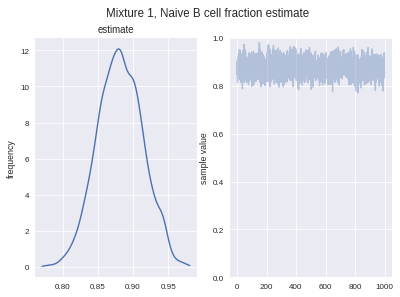

In [78]:
g = plots.traceplot(
    all_traces_df3[(all_traces_df3['sample_id'] == 1)
                   & (all_traces_df3['subset_name'] == 'B_Naive')].set_index(
                       'iter')[['estimate']],
    vars=['estimate'])
g.suptitle('Mixture 1, Naive B cell fraction estimate')
g.gca().set_ylim(0, 1)
savefig(g, 'plots/2.1.1/traceplot_mix1_naiveB.png', dpi=300)
savefig(g, 'plots/2.1.1/traceplot_mix1_naiveB.pdf', dpi=300)

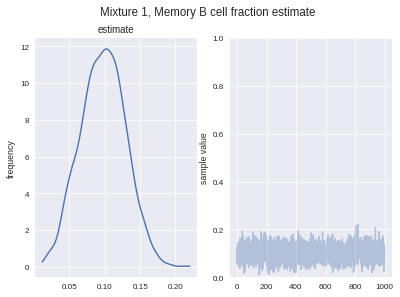

In [79]:
g = plots.traceplot(
    all_traces_df3[(all_traces_df3['sample_id'] == 1)
                   & (all_traces_df3['subset_name'] == 'B_Memory')].set_index(
                       'iter')[['estimate']],
    vars=['estimate'])
g.suptitle('Mixture 1, Memory B cell fraction estimate')
g.gca().set_ylim(0, 1)
savefig(g, 'plots/2.1.1/traceplot_mix1_memoryB.png', dpi=300)
savefig(g, 'plots/2.1.1/traceplot_mix1_memoryB.pdf', dpi=300)

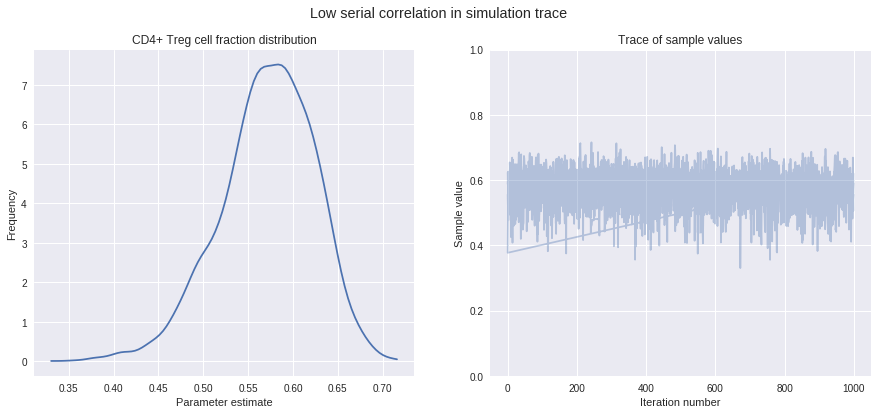

In [80]:
with sns.plotting_context('notebook'):
    g = plots.traceplot(all_traces_df3[(all_traces_df3['sample_id'] == 10) & (all_traces_df3['subset_name'] == 'CD4_Treg')]                        .set_index('iter')[['estimate']],
                        vars=['estimate'],
                       )
    g.set_size_inches((15,6))
    #g.suptitle('Mixture 10, CD4 Treg cell fraction estimate')
    g.suptitle('Low serial correlation in simulation trace')
    g.axes[0].set_ylabel('Frequency')
    g.axes[0].set_xlabel('Parameter estimate')
    g.axes[0].set_title('CD4+ Treg cell fraction distribution')
    g.axes[1].set_ylim(0,1)
    g.axes[1].set_ylabel('Sample value')
    g.axes[1].set_xlabel('Iteration number')
    g.axes[1].set_title('Trace of sample values')
    savefig(g, 'plots/2.1.1/traceplot_mix10_Treg.png', dpi=300)
    savefig(g, 'plots/2.1.1/traceplot_mix10_Treg.pdf', dpi=300)

In [81]:
# # correlation matrix

# not Omega_L
omega = stan_summary[stan_summary.name.str.startswith('Omega[')] 
omega.shape

(169, 10)

In [83]:
mean_matrix = omega['Mean'].values.reshape(13, 13)
omega_df = pd.DataFrame(mean_matrix, columns=subset_names).rename(
columns=lambda x: x.replace('_', ' '))
subset_names_cleaner = list(omega_df.columns)
omega_df

,B CD5,B Memory,B Naive,CD4 Central Memory,CD4 Effector Memory,CD4 Naive,CD4 Th1,CD4 Th17,CD4 Th2,CD4 Treg,CD8 Central Memory,CD8 Effector,CD8 Naive
0,1.000000,0.933631,0.934306,0.327230,0.253712,0.310774,0.293183,0.232115,0.219261,0.294359,0.298074,0.163747,0.268993
1,0.933631,1.000000,0.961406,0.462329,0.400880,0.458163,0.424630,0.390508,0.369654,0.411717,0.442805,0.273710,0.410071
2,0.934306,0.961406,1.000000,0.461088,0.401640,0.455601,0.436804,0.359400,0.349832,0.397334,0.429496,0.277096,0.422463
3,0.327230,0.462329,0.461088,1.000000,0.936453,0.916327,0.960339,0.926928,0.864114,0.917675,0.937105,0.793811,0.892989
4,0.253712,0.400880,0.401640,0.936453,1.000000,0.849959,0.944755,0.918480,0.877112,0.839818,0.970660,0.910692,0.863576
5,0.310774,0.458163,0.455601,0.916327,0.849959,1.000000,0.915923,0.883725,0.853770,0.798914,0.897567,0.733903,0.941709
6,0.293183,0.424630,0.436804,0.960339,0.944755,0.915923,1.000000,0.947436,0.877593,0.869367,0.948953,0.849871,0.897570
7,0.232115,0.390508,0.359400,0.926928,0.918480,0.883725,0.947436,1.000000,0.928363,0.838983,0.920713,0.802050,0.841127
8,0.219261,0.369654,0.349832,0.864114,0.877112,0.853770,0.877593,0.928363,1.000000,0.736719,0.895831,0.777019,0.808824
9,0.294359,0.411717,0.397334,0.917675,0.839818,0.798914,0.869367,0.838983,0.736719,1.000000,0.825918,0.698368,0.760709


In [84]:
subset_names_cleaner

['B CD5',
 'B Memory',
 'B Naive',
 'CD4 Central Memory',
 'CD4 Effector Memory',
 'CD4 Naive',
 'CD4 Th1',
 'CD4 Th17',
 'CD4 Th2',
 'CD4 Treg',
 'CD8 Central Memory',
 'CD8 Effector',
 'CD8 Naive']

In [85]:
omega_df.shape, mean_matrix.shape

((13, 13), (13, 13))

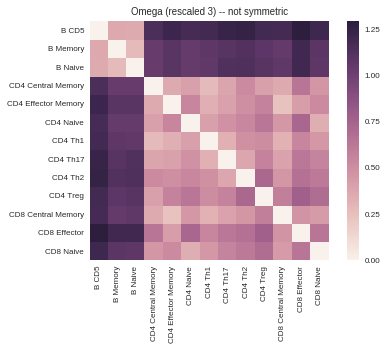

In [86]:
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
# make into distance matrix as suggested in links above
rescaled = np.sqrt(2*(1-mean_matrix))
#rescaled /= 2 # my own
g = sns.heatmap(rescaled, square=True,
                xticklabels=subset_names_cleaner,
                yticklabels=subset_names_cleaner
               )
plt.title('Omega (rescaled 3) -- not symmetric')

In [128]:
pdist = scipy.spatial.distance.squareform(rescaled)
pdist

array([ 0.36433227,  0.36247483,  1.15997414,  1.22171028,  1.17407496,
        1.18896341,  1.23926188,  1.24959113,  1.18797391,  1.18484261,
        1.29325404,  1.20913771,  0.27782728,  1.03698698,  1.09464149,
        1.04099664,  1.0727255 ,  1.10407608,  1.12280542,  1.08469627,
        1.05564672,  1.20523027,  1.08621269,  1.03818303,  1.09394698,
        1.04345484,  1.06131616,  1.13190106,  1.14032276,  1.09787613,
        1.06817976,  1.20241756,  1.07474369,  0.35650245,  0.40907945,
        0.28164162,  0.38228785,  0.52131756,  0.40577087,  0.35466886,
        0.64216665,  0.46262512,  0.54779741,  0.33240036,  0.40378212,
        0.49575801,  0.56600707,  0.24223955,  0.42262986,  0.52234854,
        0.41006585,  0.48223438,  0.54079571,  0.63417032,  0.45262125,
        0.72951628,  0.34144106,  0.32423448,  0.49478682,  0.51114186,
        0.31952152,  0.54795803,  0.45261463,  0.37851552,  0.5674804 ,
        0.39821351,  0.62920585,  0.56368963,  0.72564592,  0.45

In [129]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
links = linkage(pdist, 'ward') # row i is which clusters were merged in i-th iteration, their distance, and their sample count
print(links)
from scipy.cluster.hierarchy import cophenet
c, _ = cophenet(links, pdist)
c # want close to 1: means actual pairwise distances well preserved by hierarchical clustering

[[  4.          10.           0.24223955   2.        ]
 [  1.           2.           0.27782728   2.        ]
 [  3.           6.           0.28164162   2.        ]
 [  5.          12.           0.34144106   2.        ]
 [  7.          15.           0.37559819   3.        ]
 [  0.          14.           0.38775594   3.        ]
 [ 13.          17.           0.43756874   5.        ]
 [  8.          19.           0.54120323   6.        ]
 [  9.          20.           0.66790041   7.        ]
 [ 11.          21.           0.69893327   8.        ]
 [ 16.          22.           0.72239767  10.        ]
 [ 18.          23.           2.28588394  13.        ]]


0.96633448660324983

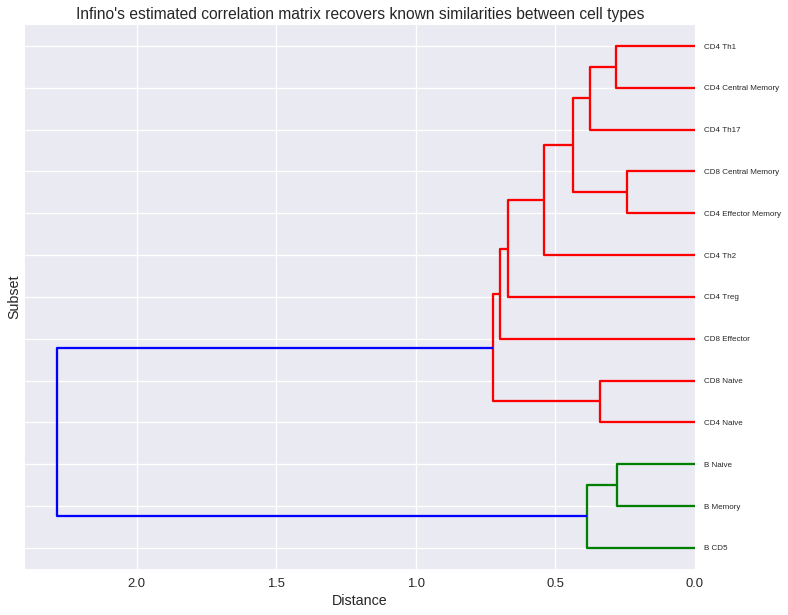

In [230]:

# plt.figure(figsize=(25, 10))
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     links,
#     leaf_rotation=90.,  # rotates the x axis labels
#     leaf_font_size=8.,  # font size for the x axis labels
#     labels=colnames_filtered
# )

with sns.plotting_context('talk'):
    f = plt.figure(figsize=(12, 10))
    dendrogram(
        links,
        #leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels=subset_names_cleaner,
        orientation='left'
    )
    plt.xlabel('Distance')
    plt.ylabel('Subset')


    #plt.title('Hierarchical clustering dendrogram from correlation matrix')
    #plt.title("Model's estimated correlation matrix recovers known biological similarities between cell types")
    plt.title("Infino's estimated correlation matrix recovers known similarities between cell types")
    savefig(f, 'plots/2.1.1/dendrogram.png', dpi=300)
    savefig(f, 'plots/2.1.1/dendrogram.pdf', dpi=300)


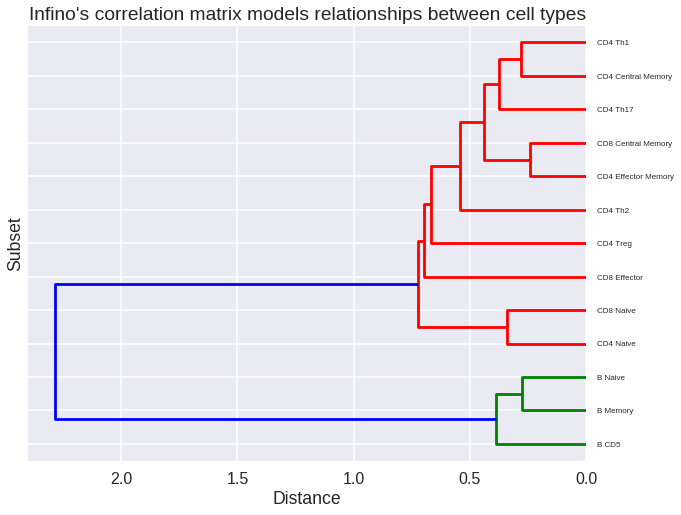

In [240]:

# plt.figure(figsize=(25, 10))
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     links,
#     leaf_rotation=90.,  # rotates the x axis labels
#     leaf_font_size=8.,  # font size for the x axis labels
#     labels=colnames_filtered
# )

with sns.plotting_context('poster'):
    f = plt.figure(figsize=(10, 8))
    dendrogram(
        links,
        #leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels=subset_names_cleaner,
        orientation='left'
    )
    plt.xlabel('Distance')
    plt.ylabel('Subset')


    #plt.title('Hierarchical clustering dendrogram from correlation matrix')
    #plt.title("Model's estimated correlation matrix recovers known biological similarities between cell types")
    plt.title("Infino's correlation matrix models relationships between cell types")
    savefig(f, 'plots/2.1.1/dendrogram.PORTRAIT.png', dpi=300)
    savefig(f, 'plots/2.1.1/dendrogram.PORTRAIT.pdf', dpi=300)


Flip from Distance to Similarity:

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
<class 'float'>


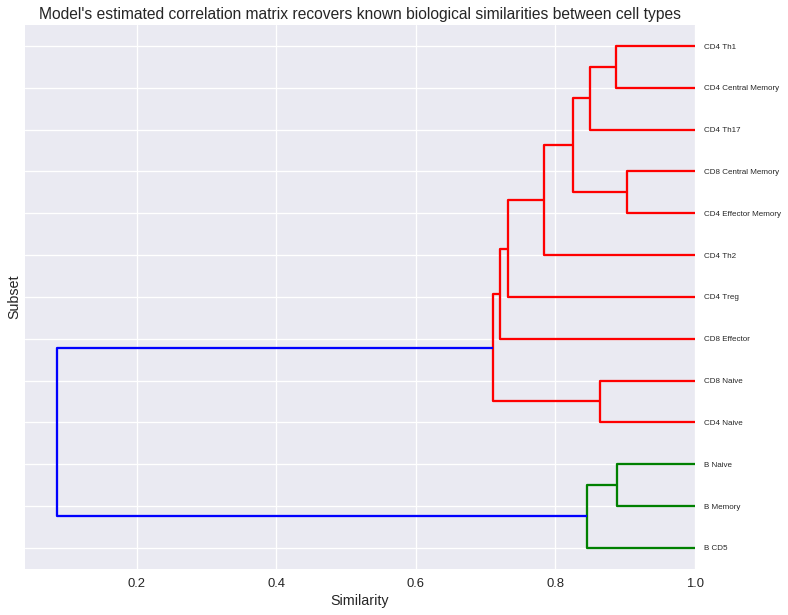

In [168]:
with sns.plotting_context('talk'):
    f = plt.figure(figsize=(12, 10))
    dendrogram(
        links,
        #leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        labels=subset_names_cleaner,
        orientation='left'
    )
    #plt.xlabel('Distance')
    plt.ylabel('Subset')


    #plt.title('Hierarchical clustering dendrogram from correlation matrix')
    plt.title("Model's estimated correlation matrix recovers known biological similarities between cell types")
    
    #plt.gca().invert_xaxis()
    ax = plt.gca()
#     lbls = plt.gca().get_xticklabels()
#     labels = [t.get_text() for t in plt.gca().get_xticklabels()]
    #labelsrev = list(reversed(labels))
    #ax.set_xticklabels(labelsrev)
    labels = ax.get_xticks().tolist()
    print(labels)
    print(type(labels[0]))
    
    # normalize
    labels_normed = [c / labels[-1] for c in labels]
    
    labelsrev = list(reversed(labels_normed))
    ax.set_xticklabels(labelsrev)
    
    plt.xlabel('Similarity')
    
    savefig(f, 'plots/2.1.1/dendrogram.SIMILARITY.png', dpi=300)
    savefig(f, 'plots/2.1.1/dendrogram.SIMILARITY.pdf', dpi=300)



Not sure if this is as interpretable. Distance between two items is easy. But how do you subtract similarities?

# Cibersort's diagnostics

* All p-values are zero. 
* RMSE ranges from 27% error to 49% error.


See below.



In [211]:
example_result

,Column,B_CD5,B_Memory,B_Naive,CD4_Central_Memory,CD4_Effector_Memory,CD4_Naive,CD4_Th1,CD4_Th17,CD4_Th2,CD4_Treg,CD8_Central_Memory,CD8_Effector,CD8_Naive,P-value,Pearson Correlation,RMSE,%Completed
0,0,0.051578,0.459352,0.222262,0.000000,0.000000,0.034986,0.060086,0.033509,0.000000,0.027812,0.000000,0.110415,0.000000,0.0,0.971789,0.283609,10.0
1,1,0.168064,0.373632,0.331475,0.032894,0.000000,0.000000,0.046191,0.000000,0.025784,0.000000,0.001223,0.020736,0.000000,0.0,0.981897,0.339896,20.0
2,2,0.000000,0.558401,0.184265,0.000000,0.000000,0.032393,0.120107,0.000000,0.000000,0.019086,0.000000,0.085748,0.000000,0.0,0.974912,0.295447,30.0
3,3,0.047419,0.568587,0.215612,0.068114,0.041023,0.000000,0.000000,0.000000,0.029918,0.000000,0.005008,0.000000,0.024319,0.0,0.986818,0.326858,40.0
4,4,0.315819,0.330829,0.110271,0.000000,0.000000,0.026783,0.020506,0.039388,0.000000,0.000000,0.000000,0.156404,0.000000,0.0,0.970967,0.273588,50.0
5,5,0.175053,0.160011,0.475554,0.018590,0.000000,0.000000,0.066602,0.006064,0.022876,0.000000,0.000000,0.047966,0.027284,0.0,0.961561,0.336366,60.0
6,6,0.290089,0.000000,0.046342,0.021105,0.036781,0.000000,0.000000,0.000000,0.003015,0.545344,0.000000,0.057323,0.000000,0.0,0.960251,0.452792,70.0
7,7,0.037475,0.007389,0.106844,0.026653,0.073152,0.000000,0.000000,0.000000,0.000000,0.737599,0.000000,0.010888,0.000000,0.0,0.975301,0.442906,80.0
8,8,0.229620,0.003317,0.219307,0.000000,0.000000,0.000000,0.072972,0.067029,0.143062,0.250220,0.014473,0.000000,0.000000,0.0,0.942548,0.410328,90.0
9,9,0.122840,0.011322,0.074285,0.000000,0.013700,0.000000,0.007480,0.090302,0.194089,0.468579,0.017404,0.000000,0.000000,0.0,0.949251,0.486806,100.0


In [213]:
example_result['P-value'].describe()

count    10.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: P-value, dtype: float64

In [212]:
# RMSE is same units as outcome (so 0 to 1)
example_result.RMSE.describe()

count    10.000000
mean      0.364860
std       0.077022
min       0.273588
25%       0.303300
50%       0.338131
75%       0.434762
max       0.486806
Name: RMSE, dtype: float64

In [215]:
print('For the simple mixture we show (mix 7):')
example_result.iloc[6]['RMSE']

For the simple mixture we show (mix 7):


0.45279228411711858

In [216]:
print('For the complex mixture we show (mix 1, rollup):')
example_result.iloc[0]['RMSE']

For the complex mixture we show (mix 1, rollup):


0.28360878427837088